## This script loads pickles of EPT files, calculates YF and median age YF, then makes 1:1 plots to compare simplified models to the most complex model.  The goal is to evaluate if and how complexity influences age metrics across scales.

#### The script reads in the model_grid.csv file for each model and uses that to tie each particle's initial location to select categories, such as the HUC, NLCD, coarse fraction, etc.  The model_grid.csv file was created via verion 2 of the general models / GRTD notebooks, tied to PFJ's repo called "GenMod" on the USGS GitLab site.

# Used to generate figures 3, 5, and 6 of FWP age comparison paper.
# Final run on ....

In [1]:
__author__ = 'Paul Juckem'
%matplotlib notebook
import os, sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from datetime import datetime
import gdal
from gdal import ogr, osr
import gen_mod_functions as gm
import flopy as fp
import pickle
from ipywidgets import interact, Dropdown, Text
from IPython.display import display
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import csv

try:
    import rasterio
except:
    print('Install rasterio into your python environment. Or, skip plotting of geotiffs at the end of this notebook')

modifier = False
def ReturnEntry(sender):
    modifier.value = intext.value

## Specify user input, including list of models to compare and which axes to plot them, plus attributes to analyze.

In [2]:
surf_aq_lays = 3  # deepest layer of the surficial aquifer.

simulate_list = ['FWP1L_zK', 'FWP5L_zK', 'FWP5L_hK']  # list of models (w/ matching directory name) to analyze
#abrevdict = {'FWP1L_zK':'1zK', 'FWP5L_zK':'5zK', 'FWP5L_hK':'5hK'}  # used to label plots
abrevdict = {'FWP1L_zK':'1-layer-zK', 'FWP5L_zK':'5-layer-zK', 'FWP5L_hK':'5-layer-hK'}  # used to label plots
nrow, ncol = 930, 650  # easier to hardcode this than waste the time to read-in a model just to get DIS info.

# for labeling RTD plots
label_by_model_name = True  # if false, will include zone info in label.

# for plotting 1:1 graphs
x1, y1, y2 = 'FWP5L_hK', 'FWP1L_zK', 'FWP5L_zK'
evaluate = ('FWP5L_hK', 'FWP5L_zK')  # which two models to compare with color flooding of model factors.  1st minus 2nd, so order matters!
#evaluate = ('FWP5L_hK', 'FWP1L_zK')  # which two models to compare with color flooding of model factors.  1st minus 2nd, so order matters!

category = 'HUC8' 

minptl = 500  # The minimum number of particles for EACH model within each HUC (eg: if FWP5L has 2000, 
               # but FWP1L has 800, none get plotted in the 1:1 plots.  Still included in the RTD plots.)
               # 500-1000 seems reasonable for 1:1 plots as it includes only HUCs with really refined RTDs;
               # however, 100 - 500 seems more reasonable if we want to visualize spatial patterns because it
               # allows more HUCs to be plotted.  100-500 is based on visually inspecting RTD curves.
                
age_cutoff = 65
#year_cutoff = '01/01/1952'              
                
# Columns in the model_grid.csv file to keep.  Purge all others.
mg_columns = ['node_num', 'row', 'col', 'HUC6', 'HUC8', 'HUC10', 'HUC12', 'ibound', 'gage_id', 'coarse_flag', 
              'qu_atlas', 'catchment', 'ssurgo', 'stream_order', 'surfmat']
                
purge_hucs = [40602, 4060200, 406020000, 40602000000]  # all hucs for Lake Michigan      

HUCshpdict = {'HUC6':'E:/HUCS/WBD_4n7/WBD_HUC6_UTMft_FWPdomain.shp', 
              'HUC8':'E:/HUCS/WBD_4n7/WBD_HUC8_UTMft_FWPdomain.shp', 
              'HUC10':'E:/HUCS/WBD_4n7/WBD_HUC10_UTMft_FWPdomain.shp', 
              'HUC12':'E:/HUCS/WBD_4n7/WBD_HUC12_UTMft_FWPdomain.shp'}

HUCtiffdict = {'HUC6':'E:/HUCS/WBD_4n7/HUC6_UTMft_FWP.tiff', 
              'HUC8':'E:/HUCS/WBD_4n7/HUC8_UTMft_FWP.tiff', 
              'HUC10':'E:/HUCS/WBD_4n7/HUC10_UTMft_FWP.tiff',
              'HUC12':'E:/HUCS/WBD_4n7/HUC12_UTMft_FWP.tiff'}

#HUCproprast = './vK_lay1_hK-vK.tif'
HUCproprastlist = ['../TIFFs/vK_lay1_5h-5z.tif', '../TIFFs/vK_lay2_5h-5z.tif', '../TIFFs/vK_lay3_5h-5z.tif', '../TIFFs/vK_lay1_hK-vK.tif',
                 '../TIFFs/vani_lay1_5h-5z.tif', '../TIFFs/vani_lay2_5h-5z.tif', '../TIFFs/vani_lay3_5h-5z.tif',
                 '../TIFFs/T_lay1_5h-5z.tif', '../TIFFs/T_lay2_5h-5z.tif', '../TIFFs/T_lay3_5h-5z.tif', '../TIFFs/GlacT_5h-5z.tif',
                 '../TIFFs/glac_satthick_5h-5z.tif', '../TIFFs/BrRCH_5h-5z.tif', '../TIFFs/RCH_5h-5z.tif', 
                 '../TIFFs/hK_lay1_5h-5z.tif', '../TIFFs/hK_lay2_5h-5z.tif', '../TIFFs/hK_lay3_5h-5z.tif',
                 '../TIFFs/BrT_5h-5z.tif', '../TIFFs/glacT2BrT_5h-5z.tif', '../TIFFs/RCHUZF_5h-5z.tif', '../TIFFs/UZF_5h-5z.tif', 
                 '../TIFFs/RCHcbb_5h-5z.tif', '../TIFFs/rch-over-satKs_5h-5z.tif', '../TIFFs/sat-weighted_Ks_5h-5z.tif']
HUCfluxrastlist = ['../TIFFs/SFR_5h-5z.tif']  # '../TIFFs/MNW2_5h-5z.tif', '../TIFFs/SWleak_5h-5z.tif',
#dischargerastdict = {'FWP1L_zK': '../TIFFs/FWP1L_zK_SFRSWleak.tif', 'FWP5L_zK':'../TIFFs/FWP5L_zK_SFRSWleak.tif', 'FWP5L_hK':
#                     '../TIFFs/FWP5L_hK_SFRSWleak.tif'}
dischargerastdict = {'FWP1L_zK': '../TIFFs/FWP1L_zK_SFRgain.tif', 'FWP5L_zK':'../TIFFs/FWP5L_zK_SFRgain.tif', 'FWP5L_hK':
                     '../TIFFs/FWP5L_hK_SFRgain.tif'}
lossrastdict = {'FWP1L_zK': '../TIFFs/FWP1L_zK_SFRloss.tif', 'FWP5L_zK':'../TIFFs/FWP5L_zK_SFRloss.tif', 'FWP5L_hK':
                     '../TIFFs/FWP5L_hK_SFRloss.tif'}
genHUCdict = {'Oconto':'04030104', 'TWR':'0403020218'}
streamorderrast = 'D:/PFJDATA/Projects/NAWQA/FWP/ARC/SFR/FWP_SFRorder.tiff'

### Prep the script for the models to be analyzed

In [3]:
homes = ['../Models']
fig_dir = '../Figures'

if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

mfpth = '../executables/MODFLOW-NWT_1.0.9/bin/MODFLOW-NWT_64.exe'
mp_exe_name = '../executables/modpath.6_0/bin/mp6x64.exe' 

dir_list = []
modlist = []
i = 0
r = 0

path_dict = {}
dfdict = {}
totp = {}
for home in homes:
    if os.path.exists(home):
        for dirpath, dirnames, filenames in os.walk(home):
            for f in filenames:
                if os.path.splitext(f)[-1] == '.nam':
                    mod = os.path.splitext(f)[0]
                    i += 1
                    if mod in simulate_list:
                        modlist.append(mod)
                        dir_list.append(dirpath)
                        r += 1
                        path_dict[mod] = dirpath
                               
print('    {} models read'.format(i))
print('These {} models will be analyzed: {}'.format(r, modlist))

    19 models read
These 3 models will be analyzed: ['FWP1L_zK', 'FWP5L_hK', 'FWP5L_zK']


### Get some functions taken care of right off the bat

In [4]:
#  https://stackoverflow.com/questions/20144529/shifted-colorbar-matplotlib/20146989#20146989
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [5]:
# populate DF with zonal stats
def hucpropstats2(hucrast, proprast, dataframe, raster_file, metric, descriptor):  # fluxtype, mod_factor
    #descriptor = '{}_{}_{}'.format(metric, fluxtype, mod_factor)
    df = dataframe.copy()
    #df[metric] = 0  # initialize
    df[descriptor] = 0  # initialize
    u = np.unique(hucrast)
    if max(u) < 10000:  # Less than any HUC6 ID number
        with open(raster_file.split('.')[0] + '_crossref.txt', mode='r') as infile:
            reader = csv.reader(infile)
            next(reader, None)  # skip the headers
            crossdict = {int(rows[0]):np.int64(rows[1]) for rows in reader}

    for ID in u[u>0]:  # HUC IDs in active part of model (not ID zero)
        idarr = np.zeros_like(hucrast)
        idarr[hucrast==ID] = 1
        hucprop = idarr * proprast
        hucprop[hucprop==0] = np.nan
        pmn, pmed, psum, pmin, pmax, pstd, pcount = np.nanmean(hucprop), np.nanmedian(hucprop), np.nansum(hucprop), np.nanmin(hucprop), np.nanmax(hucprop), np.nanstd(hucprop), np.count_nonzero(~np.isnan(hucprop))
        prange = pmax - pmin
        metricdict = {'mean':pmn, 'median':pmed, 'sum':psum, 'min':pmin, 'max':pmax, 'range':prange, 'std':pstd, 'count':pcount}
        if max(u) < 10000:
            # assigned the appropriate zonal data
            #df[metric].loc[df.index==crossdict[ID]] = metricdict[metric].astype('float64')              
            try:
                df[descriptor].loc[df.index==crossdict[ID]] = metricdict[metric].astype('float64')              
            except:
                df[descriptor].loc[df.index==crossdict[ID]] = int(metricdict[metric])
        else:
            # assigned the appropriate zonal data
            #df[metric].loc[df.index==ID] = metricdict[metric].astype('float64')  
            try:
                df[descriptor].loc[df.index==ID] = metricdict[metric].astype('float64')  
            except:
                df[descriptor].loc[df.index==ID] = int(metricdict[metric])
    return(df)

### OK, start processing files and do some math

In [6]:
# read-in the model_grid.csv file for each model.  Then create a dataframe from each csv & pickle file.

dfdict = {}
totp = {}

for model in modlist:
    g = os.path.join(path_dict[model], 'model_grid.csv')
    z = os.path.join(path_dict[model], 'zone_df.csv')
    try:
        df = pd.read_csv(g)
        df.ibound.replace(0, np.nan, inplace=True)
        df = df[df.ibound.notnull()]
        df = df[mg_columns]  # keep just the desired fields
        # re-calculate 2D cell number b/c node_num is computed differently for model_grid.csv and what's in the ept file.
        df['cellnum2d'] = df.row * ncol + df.col
        
        zone_df = pd.read_csv(z, index_col=0)
        for group in zone_df:
            print('\nReading-in the EPT pickle file for {} in {}'.format(group, model))
            #if group == 'all_zones':
            #    p = os.path.join(path_dict[model], '{}_flux_all_zones_mod.pickle'.format(model))
                #mnz = '{}_all_zones'.format(model)
            #else:
            p = os.path.join(path_dict[model], '{}_flux_{}_mod.pickle'.format(model, group))
            mnz = '{}_{}'.format(model, group)
            eptu = pd.read_pickle(open(p, 'rb'))
            eptu['cellnum2d'] = (eptu['Initial Row']-1) * ncol + (eptu['Initial Column'] -1)  # -1 to convert to 0-based
            eptu_mg = eptu.join(df, on='cellnum2d', lsuffix='_ept', rsuffix='_mg')
            eptu_mg = eptu_mg[eptu_mg['Initial Layer'] <= surf_aq_lays]  # ensure that we're only analyzing Glacial!
            #dfdict[model] = eptu_mg
            dfdict[mnz] = eptu_mg
            totp[mnz] = eptu_mg.rt.count()
            
    except (AttributeError, ValueError, IOError, IndexError):
        print('ERROR. THIS CODE BLOCK DID NOT COMPLETE. TROUBLE-SHOOT AND TRY AGAIN')
        print('The error occured while working on this model: {}'.format(model))
        raise SystemExit()

eptlist = list(dfdict.keys())
print('....done')


Reading-in the EPT pickle file for all_zones in FWP1L_zK


C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)



Reading-in the EPT pickle file for zones[1] in FWP5L_hK

Reading-in the EPT pickle file for zones[1] in FWP5L_zK
....done


In [7]:
print(eptlist)
print(modlist)

['FWP1L_zK_all_zones', 'FWP5L_hK_zones[1]', 'FWP5L_zK_zones[1]']
['FWP1L_zK', 'FWP5L_hK', 'FWP5L_zK']


<IPython.core.display.Javascript object>


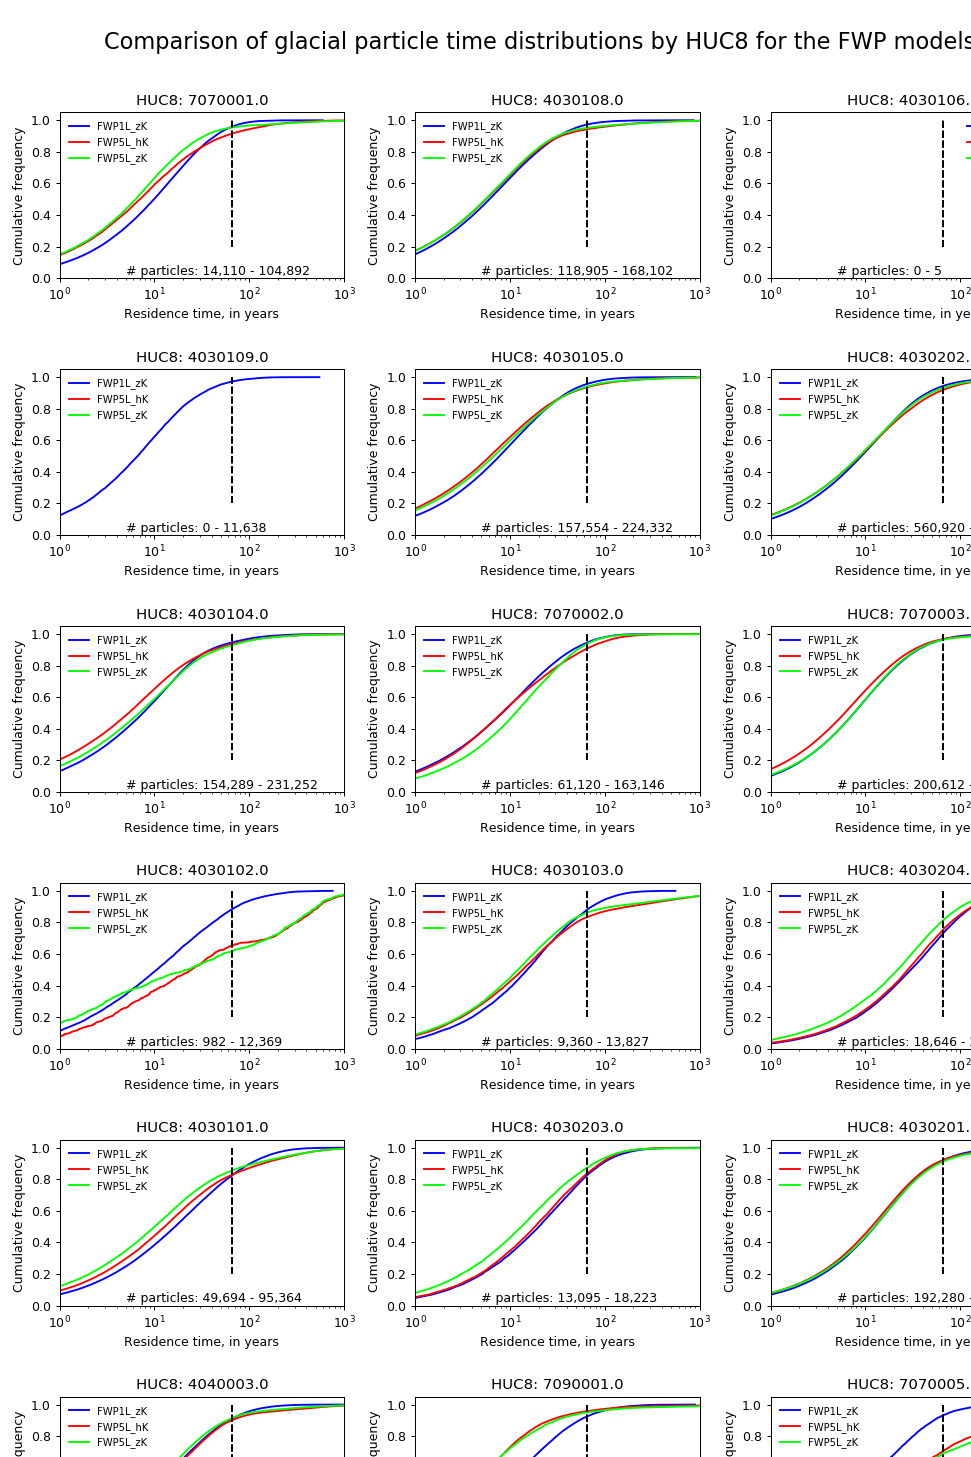

In [8]:
# Plot age distributions for all 3 models by HUC ID, for selected HUC scale.

#uniques = dfdict[modlist[0]][category].unique()
uniques = dfdict[eptlist[0]][category].unique()
# remove any HUCs listed in purge_hucs
for h in purge_hucs:
    ind = np.where(uniques==h)
    uniques = np.delete(uniques, ind)

n_uni = len(uniques)
sum_p = {}
#for mn in modlist:
for mn in eptlist:
    sum_p[mn] = 0
    
if n_uni <= 20:
    vplots = int(np.ceil(n_uni/ 3.0))
    figsize = (12, 3*vplots)
    CS, CSaxes = plt.subplots(vplots, 3, figsize=figsize)
else:
    hplots = int(np.round(np.sqrt(n_uni)))
    vplots = int(np.ceil(np.sqrt(n_uni)))
    figsize = (hplots*4, hplots*3)
    CS, CSaxes = plt.subplots(vplots, hplots, figsize=figsize)
        
#colors_line = plt.cm.brg(np.linspace(0, 1, len(modlist)))
colors_line = plt.cm.brg(np.linspace(0, 1, len(eptlist)))

for ax, cat_val in zip(CSaxes.flat, uniques):
    n = []
    #for i, md in enumerate(modlist):
    for i, md in enumerate(eptlist):
        rt = dfdict[md].loc[dfdict[md][category]==cat_val, 'rt']  # 'rt' is "raw time" in the dataframe
        rt.sort_values(inplace=True)
        n.append(rt.count())
        sum_p[md] = sum_p[md] + rt.count()
        y_rt = np.linspace(0, 1, rt.shape[0])
    
        if label_by_model_name:
            label = modlist[i]
        else:
            label = md
        ax.plot(rt, y_rt, c=colors_line[i], label=label)
        ax.plot((age_cutoff, age_cutoff), (0.2, 1), 'k--')
        
        title = '{}: {}'.format(category, cat_val)
        ax.set_title(title, fontsize=12)

        ax.set_xscale('log')
        ax.set_xlim(1e0, 1e3)
        ax.set_ylim(0, )

        ax.legend(loc=0, frameon=False, fontsize=8)#, bbox_to_anchor=(0.20, 0.2), ncol=1)
        ax.set_xlabel('Residence time, in years')
        ax.set_ylabel('Cumulative frequency')
        if len(n) == len(modlist):
            nmin, nmax = min(n), max(n)
            ax.text(5,0.02, '# particles: {:,} - {:,}'.format(nmin, nmax))
        
CS.suptitle('Comparison of glacial particle time distributions by {} for the FWP models'.format(category), fontsize=18)  
CS.tight_layout()

if n_uni < 18:
    #CS.subplots_adjust(top= 0.86, hspace=0.85)
    CS.subplots_adjust(top= 0.86)
elif n_uni < 100:
    CS.subplots_adjust(top= 0.93, hspace=0.55)
elif n_uni < 400:
    CS.subplots_adjust(top= 0.95, hspace=0.55)
else:
    CS.subplots_adjust(top= 0.97, hspace=0.55)

#dst = 'RTD_compare--{}'.format(category)
#dst_pth = os.path.join(fig_dir, dst)
#plt.savefig(dst_pth)
#plt.close()

<IPython.core.display.Javascript object>


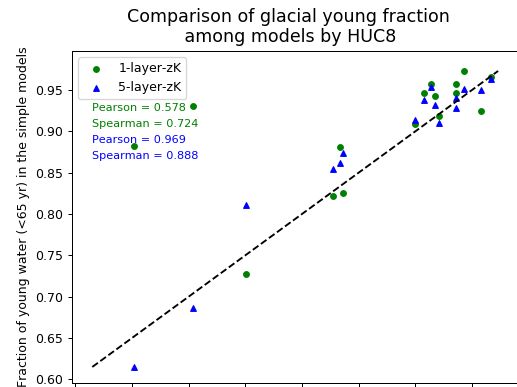

In [9]:
# 1:1 plot of Young Fraction btwn 5LhK against 1L and 5LzK models for select HUC scale.

uniques = dfdict[eptlist[0]][category].unique()
# remove any HUCs listed in purge_hucs
for h in purge_hucs:
    ind = np.where(uniques==h)
    uniques = np.delete(uniques, ind)

yfhucdict = {}
yfvalues = []
skiphuc = []
for j, cat_val in enumerate(uniques):  # each HUC ID
    yfmoddict = {}
    #for i, md in enumerate(modlist):  # each of the 3 FWP models
    for i, md in enumerate(eptlist):  # each of the 3 FWP models
        mn = modlist[i]
        #df = dfdict[md].loc[dfdict[md][category]==cat_val]  # old way
        df = dfdict[md][dfdict[md][category]==cat_val].copy()
        if df.rt.count() >= minptl:
            youngdf = df.loc[df.rt < age_cutoff]
            yf = youngdf.rt.count() / df.rt.count()
            yfmoddict[mn] = yf
            yfvalues.append(yf)
        else:
            skiphuc.append(cat_val)
            break
    if cat_val not in skiphuc:
        yfhucdict[cat_val] = yfmoddict    
        
ddd = pd.DataFrame(yfhucdict).T
#print(mean_squared_error(np.array(ddd[x1]), np.array(ddd[y1])))
#r2_y1 = r2_score(np.array(ddd[x1]), np.array(ddd[y1]))
#r2_y2 = r2_score(np.array(ddd[x1]), np.array(ddd[y2]))
#print(r2_y1)
#print(r2_y2)
Prho_y1, Pp_y1 = stats.pearsonr(np.array(ddd[x1]), np.array(ddd[y1]))
Srho_y1, Sp_y1 = stats.spearmanr(np.array(ddd[x1]), np.array(ddd[y1]))
Prho_y2, Pp_y2 = stats.pearsonr(np.array(ddd[x1]), np.array(ddd[y2]))
Srho_y2, Sp_y2 = stats.spearmanr(np.array(ddd[x1]), np.array(ddd[y2]))

ax = ddd.plot(kind='scatter', x=x1, y=y1, marker='o', color='green', label='1-layer-zK')
ddd.plot(kind='scatter', x=x1, y=y2, marker='^', color='blue', label = '5-layer-zK', ax=ax)
mini, maxi = min(yfvalues), max(yfvalues)
y1x = maxi - ((maxi-mini)/2)
ax.plot((mini, maxi), (mini, maxi), 'k--')
plt.xlabel('Fraction of young water (<{} yr) in the complex model'.format(age_cutoff))
plt.ylabel('Fraction of young water (<{} yr) in the simple models'.format(age_cutoff))
plt.suptitle('Comparison of glacial young fraction\n among models by {}'.format(category), fontsize=14)
#ax.text(0.76, maxi, 'R2 = {:3.3f}'.format(r2_y1), fontsize=9, color='green')
#ax.text(0.76, maxi-0.02, 'R2 = {:3.3f}'.format(r2_y2), fontsize=9, color='blue')
ax.text(mini, 0.95*maxi, 'Pearson = {:3.3f}'.format(Prho_y1), fontsize=9, color='green')
ax.text(mini, 0.93*maxi, 'Spearman = {:3.3f}'.format(Srho_y1), fontsize=9, color='green')
ax.text(mini, 0.91*maxi, 'Pearson = {:3.3f}'.format(Prho_y2), fontsize=9, color='blue')
ax.text(mini, 0.89*maxi, 'Spearman = {:3.3f}'.format(Srho_y2), fontsize=9, color='blue')

dst = 'YFrac_glac_121_{}'.format(category)
#loc = os.path.dirname(path[modlist[0]])  # should go up one directory to the dir that houses all of the models.
#dst_pth = os.path.join(loc, dst)
#dst_pth = os.path.join(fig_dir, dst)
#plt.savefig(dst_pth)
#plt.close() 

# Figure 3 of the FWP comparison paper.  Last edited/generated 1/31/19

<IPython.core.display.Javascript object>


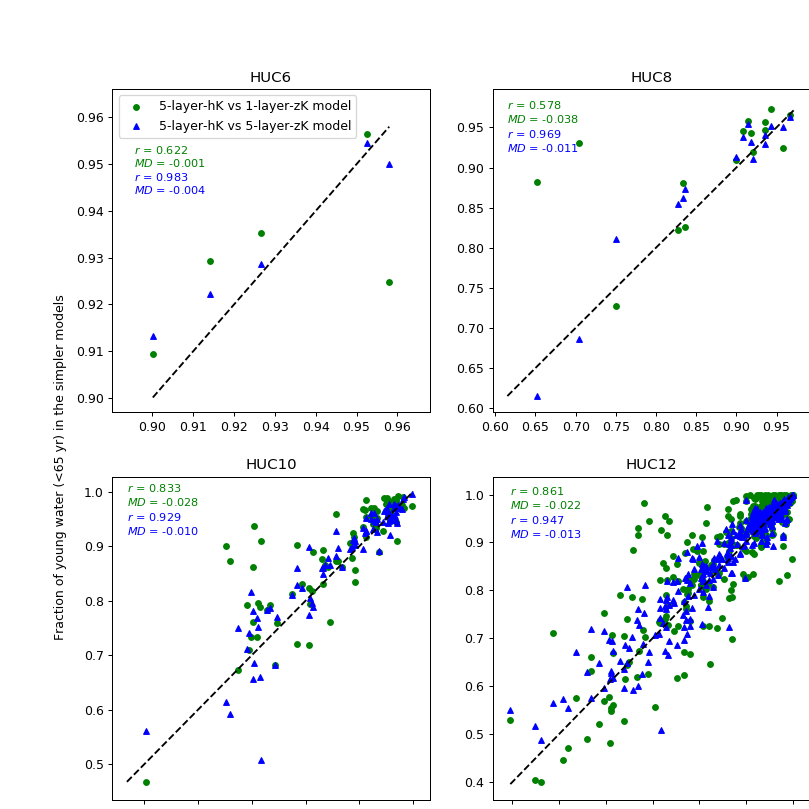

In [41]:
# 1:1 plot of Young Fraction btwn 5LhK against 1L and 5LzK models for ALL HUC scales.

hucs = ['HUC6', 'HUC8', 'HUC10', 'HUC12']
nhucs = len(hucs)
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axisdict = {0:ax1, 1:ax2, 2:ax3, 3:ax4}

for k, each in enumerate(hucs):
    # make sure we get ALL unique HUC IDs
    u1 = dfdict[eptlist[0]][each].unique()
    u2 = dfdict[eptlist[1]][each].unique()
    u3 = dfdict[eptlist[2]][each].unique()
    u = np.append(u1, u2)
    u = np.append(u, u3)
    uniques = np.unique(u)
    # remove any HUCs listed in purge_hucs
    for h in purge_hucs:
        ind = np.where(uniques==h)
        uniques = np.delete(uniques, ind)
    axis = axisdict[k]

    yfhucdict = {}
    yfvalues = []
    skiphuc = []
    for j, cat_val in enumerate(uniques):  # each HUC ID
        yfmoddict = {}
        for i, md in enumerate(eptlist):  # each of the 3 FWP models
            mn = modlist[i]
            df = dfdict[md].loc[dfdict[md][each]==cat_val]
            if df.rt.count() >= minptl:
                youngdf = df.loc[df.rt < age_cutoff]
                yf = youngdf.rt.count() / df.rt.count()
                yfmoddict[mn] = yf
                yfvalues.append(yf)
            else:
                skiphuc.append(cat_val)
                break
        if cat_val not in skiphuc:
            yfhucdict[cat_val] = yfmoddict    

    ddd = pd.DataFrame(yfhucdict).T
    #r2_y1 = r2_score(np.array(ddd[x1]), np.array(ddd[y1]))
    #r2_y2 = r2_score(np.array(ddd[x1]), np.array(ddd[y2]))
    Prho_y1, Pp_y1 = stats.pearsonr(np.array(ddd[x1]), np.array(ddd[y1]))
    Srho_y1, Sp_y1 = stats.spearmanr(np.array(ddd[x1]), np.array(ddd[y1]))
    std_y1 = stats.tstd(np.array(ddd[x1]) - np.array(ddd[y1]))
    ME_y1 = np.mean(np.array(ddd[x1]) - np.array(ddd[y1]))
    Prho_y2, Pp_y2 = stats.pearsonr(np.array(ddd[x1]), np.array(ddd[y2]))
    Srho_y2, Sp_y2 = stats.spearmanr(np.array(ddd[x1]), np.array(ddd[y2]))
    std_y2 = stats.tstd(np.array(ddd[x1]) - np.array(ddd[y2]))
    ME_y2 = np.mean(np.array(ddd[x1]) - np.array(ddd[y2]))
    
    
    #plotting
    mini, maxi = min(yfvalues), max(yfvalues)
    yrange = maxi-mini
    if k == 0:
        ddd.plot(kind='scatter', x=x1, y=y1, marker='o', color='green', label='5-layer-hK vs 1-layer-zK model', ax=axis)
        ddd.plot(kind='scatter', x=x1, y=y2, marker='^', color='blue', label = '5-layer-hK vs 5-layer-zK model', ax=axis)
        #axis.text(mini-0.05, mini+0.90*yrange, 'R2 = {:3.3f}'.format(r2_y1), fontsize=9, color='green')
        #axis.text(mini-0.05, mini+0.85*yrange, 'R2 = {:3.3f}'.format(r2_y2), fontsize=9, color='blue')
        axis.text(mini*.995, mini+0.90*yrange, r'$r$ = {:3.3f}'.format(Prho_y1), fontsize=9, color='green')
        #axis.text(mini*.995, mini+0.85*yrange, r'$r_s$ = {:3.3f}'.format(Srho_y1), fontsize=9, color='green')
        #axis.text(mini*.995, mini+0.80*yrange, r'$std$ = {:3.3f}'.format(std_y1), fontsize=9, color='green')
        axis.text(mini*.995, mini+0.85*yrange, r'$MD$ = {:3.3f}'.format(ME_y1), fontsize=9, color='green')
        axis.text(mini*.995, mini+0.80*yrange, r'$r$ = {:3.3f}'.format(Prho_y2), fontsize=9, color='blue')
        #axis.text(mini*.995, mini+0.70*yrange, r'$r_s$ = {:3.3f}'.format(Srho_y2), fontsize=9, color='blue')
        #axis.text(mini*.995, mini+0.60*yrange, r'$std$ = {:3.3f}'.format(std_y2), fontsize=9, color='blue')
        axis.text(mini*.995, mini+0.75*yrange, r'$MD$ = {:3.3f}'.format(ME_y2), fontsize=9, color='blue')
    else:
        ddd.plot(kind='scatter', x=x1, y=y1, marker='o', color='green', ax=axis)
        ddd.plot(kind='scatter', x=x1, y=y2, marker='^', color='blue', ax=axis)
        #axis.text(mini, mini+yrange, 'R2 = {:3.3f}'.format(r2_y1), fontsize=9, color='green')
        #axis.text(mini, mini+0.95*yrange, 'R2 = {:3.3f}'.format(r2_y2), fontsize=9, color='blue')
        #axis.text(mini, mini+yrange, 'Pearson = {:3.3f}'.format(Prho_y1), fontsize=9, color='green')
        axis.text(mini, mini+yrange, r'$r$ = {:3.3f}'.format(Prho_y1), fontsize=9, color='green')
        #axis.text(mini, mini+0.95*yrange, r'$r_s$ = {:3.3f}'.format(Srho_y1), fontsize=9, color='green')
        #axis.text(mini, mini+0.90*yrange, r'$std$ = {:3.3f}'.format(std_y1), fontsize=9, color='green')
        axis.text(mini, mini+0.95*yrange, r'$MD$ = {:3.3f}'.format(ME_y1), fontsize=9, color='green')
        axis.text(mini, mini+0.90*yrange, r'$r$ = {:3.3f}'.format(Prho_y2), fontsize=9, color='blue')
        #axis.text(mini, mini+0.80*yrange, r'$r_s$ = {:3.3f}'.format(Srho_y2), fontsize=9, color='blue')
        #axis.text(mini, mini+0.70*yrange, r'$std$ = {:3.3f}'.format(std_y2), fontsize=9, color='blue')
        axis.text(mini, mini+0.85*yrange, r'$MD$ = {:3.3f}'.format(ME_y2), fontsize=9, color='blue')
        
    axis.plot((mini, maxi), (mini, maxi), 'k--')
    axis.set_xlabel(''), axis.set_ylabel('')
    axis.set_title(each)
    
    # Add an attribute to the HUC shapefile
    shapefile = HUCshpdict[each]
    shp = gpd.read_file(shapefile)  
    shp[each] = shp[each].astype('int64')  # convert so can merge
    ddd.index = ddd.index.astype('int64')  # convert so can merge
    ddd['YF_hK-1L'] = ddd[x1] - ddd[y1]
    ddd['YF_hK-zK'] = ddd[x1] - ddd[y2]

    df = pd.merge(shp, ddd, how='outer', left_on=each, right_index=True)
    dst = shapefile[:-4] + '_YF.shp'
    df.to_file(dst)

fig.text(0.5, 0.06, 'Fraction of young water (<{} yr) in the complex (5-layer-hK) model'.format(age_cutoff), ha='center')
fig.text(0.06, 0.48, 'Fraction of young water (<{} yr) in the simpler models'.format(age_cutoff), va='center', rotation='vertical')
plt.subplots_adjust(top = .9)
#fig.suptitle('Comparison of glacial aquifer\n young fractions by HUCs', fontsize=14)

dst = 'YFrac_glac_121_allHUCs'
dst_pth = os.path.join(fig_dir, dst)
plt.savefig(dst_pth)
#plt.close()

<IPython.core.display.Javascript object>


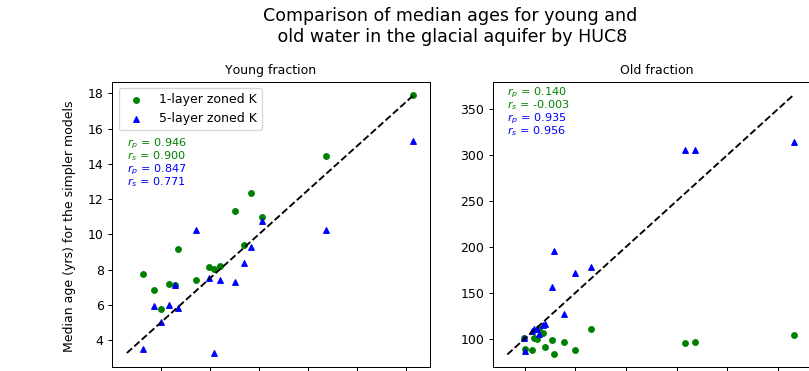

In [11]:
# 1:1 plot of meanYoungAge and meanOldAge btwn 5LhK against 1L and 5LzK models for select HUC scale.

# make sure we get ALL unique HUC IDs
u1 = dfdict[eptlist[0]][category].unique()
u2 = dfdict[eptlist[1]][category].unique()
u3 = dfdict[eptlist[2]][category].unique()
u = np.append(u1, u2)
u = np.append(u, u3)
uniques = np.unique(u)
# remove any HUCs listed in purge_hucs
for h in purge_hucs:
    ind = np.where(uniques==h)
    uniques = np.delete(uniques, ind)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.6))

skiphuc = []
yfhucdict = {}
yfvalues = []
ofhucdict = {}
ofvalues = []
for j, cat_val in enumerate(uniques):  # each HUC ID
    yfmoddict = {}
    ofmoddict = {}
    for i, md in enumerate(eptlist):  # each of the 3 FWP models
        mn = modlist[i]
        df = dfdict[md].loc[dfdict[md][category]==cat_val]
        if df.rt.count() >= minptl:
            youngdf = df.loc[df.rt < age_cutoff]
            olddf = df.loc[df.rt >= age_cutoff]
            yfage = youngdf.rt.median()
            ofage = olddf.rt.median()
            yfmoddict[mn] = yfage
            yfvalues.append(yfage) 
            ofmoddict[mn] = ofage
            ofvalues.append(ofage)
        else:
            skiphuc.append(cat_val)
            break
    if cat_val not in skiphuc:
        yfhucdict[cat_val] = yfmoddict
        ofhucdict[cat_val] = ofmoddict
        
young = pd.DataFrame(yfhucdict).T
old = pd.DataFrame(ofhucdict).T
#r2_y1y = r2_score(np.array(young[x1]), np.array(young[y1]))
#r2_y2y = r2_score(np.array(young[x1]), np.array(young[y2]))
#r2_y1o = r2_score(np.array(old[x1]), np.array(old[y1]))
#r2_y2o = r2_score(np.array(old[x1]), np.array(old[y2]))
Prho_y1y, Pp_y1y = stats.pearsonr(np.array(young[x1]), np.array(young[y1]))
Srho_y1y, Sp_y1y = stats.spearmanr(np.array(young[x1]), np.array(young[y1]))
Prho_y2y, Pp_y2y = stats.pearsonr(np.array(young[x1]), np.array(young[y2]))
Srho_y2y, Sp_y2y = stats.spearmanr(np.array(young[x1]), np.array(young[y2]))
Prho_y1o, Pp_y1o = stats.pearsonr(np.array(old[x1]), np.array(old[y1]))
Srho_y1o, Sp_y1o = stats.spearmanr(np.array(old[x1]), np.array(old[y1]))
Prho_y2o, Pp_y2o = stats.pearsonr(np.array(old[x1]), np.array(old[y2]))
Srho_y2o, Sp_y2o = stats.spearmanr(np.array(old[x1]), np.array(old[y2]))

#plotting
miny, maxy = min(yfvalues), max(yfvalues)
mino, maxo = min(ofvalues), max(ofvalues)
yrange_y = maxy-miny
yrange_o = maxo-mino

young.plot(kind='scatter', x=x1, y=y1, marker='o', c='green', label='1-layer zoned K', ax=ax1)
young.plot(kind='scatter', x=x1, y=y2, marker='^', c='blue', label='5-layer zoned K', ax=ax1)
old.plot(kind='scatter', x=x1, y=y1, marker='o', c='green', ax=ax2)
old.plot(kind='scatter', x=x1, y=y2, marker='^', c='blue', ax=ax2)
#ax1.text(miny, miny+0.80*yrange_y, 'R2 = {:3.3f}'.format(r2_y1y), fontsize=9, color='green')
#ax1.text(miny, miny+0.75*yrange_y, 'R2 = {:3.3f}'.format(r2_y2y), fontsize=9, color='blue')
#ax2.text(mino, mino+yrange_o, 'R2 = {:3.3f}'.format(r2_y1o), fontsize=9, color='green')
#ax2.text(mino, mino+0.95*yrange_o, 'R2 = {:3.3f}'.format(r2_y2o), fontsize=9, color='blue')
ax1.text(miny, miny+0.80*yrange_y, r'$r_p$ = {:3.3f}'.format(Prho_y1y), fontsize=9, color='green')
ax1.text(miny, miny+0.75*yrange_y, r'$r_s$ = {:3.3f}'.format(Srho_y1y), fontsize=9, color='green')
ax1.text(miny, miny+0.70*yrange_y, r'$r_p$ = {:3.3f}'.format(Prho_y2y), fontsize=9, color='blue')
ax1.text(miny, miny+0.65*yrange_y, r'$r_s$ = {:3.3f}'.format(Srho_y2y), fontsize=9, color='blue')
ax2.text(mino, mino+yrange_o, r'$r_p$ = {:3.3f}'.format(Prho_y1o), fontsize=9, color='green')
ax2.text(mino, mino+0.95*yrange_o, r'$r_s$ = {:3.3f}'.format(Srho_y1o), fontsize=9, color='green')
ax2.text(mino, mino+0.90*yrange_o, r'$r_p$ = {:3.3f}'.format(Prho_y2o), fontsize=9, color='blue')
ax2.text(mino, mino+0.85*yrange_o, r'$r_s$ = {:3.3f}'.format(Srho_y2o), fontsize=9, color='blue')

ax1.plot((miny, maxy), (miny, maxy), 'k--')
ax2.plot((mino, maxo), (mino, maxo), 'k--')
ax1.set_xlabel(''), ax1.set_ylabel(''), ax2.set_ylabel(''), ax2.set_xlabel('')
fig.text(0.25, 0.82, 'Young fraction')
fig.text(0.73, 0.82, 'Old fraction', ha='center')
fig.text(0.07, 0.45, 'Median age (yrs) for the simpler models', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Median age (yrs) for the complex model', ha='center')
plt.subplots_adjust(top = .8)
fig.suptitle('Comparison of median ages for young and\n old water in the glacial aquifer by {}'.format(category), fontsize=14)
#fig.tight_layout()

dst = 'YnOages_121_{}'.format(category)
#loc = os.path.dirname(path[modlist[0]])  # should go up one directory to the dir that houses all of the models.
#dst_pth = os.path.join(loc, dst)
dst_pth = os.path.join(fig_dir, dst)
plt.savefig(dst_pth)
#plt.close()

In [ ]:
# 1:1 plot of meanYoungAge and meanOldAge btwn 5LhK against 1L and 5LzK models for ALL HUC scales.

# Better viewed as separate plots via code block below
'''
hucs = ['HUC6', 'HUC8', 'HUC10', 'HUC12']
nhucs = len(hucs)
fig, [[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]] = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
youngaxisdict = {0:ax1, 1:ax2, 2:ax5, 3:ax6}
oldaxisdict = {0:ax3, 1:ax4, 2:ax7, 3:ax8}

for k, each in enumerate(hucs):
    # make sure we get ALL unique HUC IDs
    u1 = dfdict[eptlist[0]][each].unique()
    u2 = dfdict[eptlist[1]][each].unique()
    u3 = dfdict[eptlist[2]][each].unique()
    u = np.append(u1, u2)
    u = np.append(u, u3)
    uniques = np.unique(u)
    # remove any HUCs listed in purge_hucs
    for h in purge_hucs:
        ind = np.where(uniques==h)
        uniques = np.delete(uniques, ind)
    youngaxis = youngaxisdict[k]
    oldaxis = oldaxisdict[k]
    ofhucdict = {}
    yfhucdict = {}
    yfvalues = []
    ofvalues = []
    skiphuc = []
    for j, cat_val in enumerate(uniques):  # each HUC ID
        yfmoddict = {} 
        ofmoddict = {} 
        for i, md in enumerate(eptlist):  # each of the 3 FWP models
            mn = modlist[i]
            df = dfdict[md].loc[dfdict[md][each]==cat_val]
            if df.rt.count() >= minptl:
                youngdf = df.loc[df.rt < age_cutoff]
                olddf = df.loc[df.rt >= age_cutoff]
                yfage = youngdf.rt.median()
                ofage = olddf.rt.median()
                yfmoddict[mn] = yfage
                yfvalues.append(yfage) 
                ofmoddict[mn] = ofage
                ofvalues.append(ofage)
                # pull out raw time info for generalized model areas for later use...
                if (cat_val == float(genHUCdict['Oconto'])) and ('fwp5lzk' in mn):  # 5lzK is the most similar to Generalized models
                    FWPzKocontoDF = df.copy()
                #elif cat_val == float(genHUCdict['TWR'])  and (md == 'fwp5lzk'):
                elif cat_val == float(genHUCdict['TWR'])  and ('fwp5lzk' in mn):
                    FWPzKtwrDF = df.copy()
                elif (cat_val == float(genHUCdict['Oconto'])) and ('fwp5lhk' in mn):  # 5lzK is the most similar to Generalized models
                    FWPhKocontoDF = df.copy()
                elif cat_val == float(genHUCdict['TWR'])  and ('fwp5lhk' in mn):
                    FWPhKtwrDF = df.copy()
                elif (cat_val == float(genHUCdict['Oconto'])) and ('fwp1l' in mn):  # 5lzK is the most similar to Generalized models
                    FWP1locontoDF = df.copy()
                elif cat_val == float(genHUCdict['TWR'])  and ('fwp1l' in mn):
                    FWP1ltwrDF = df.copy()                    
            else:
                skiphuc.append(cat_val)
                break
        if cat_val not in skiphuc:
            yfhucdict[cat_val] = yfmoddict
            ofhucdict[cat_val] = ofmoddict            
            
    young = pd.DataFrame(yfhucdict).T
    old = pd.DataFrame(ofhucdict).T
    for n in modlist:
        young = young.loc[~young[n].isnull()]  # need to remove any NANs
        old = old.loc[~old[n].isnull()]  # need to remove any NANs
    r2_y1y = r2_score(np.array(young[x1]), np.array(young[y1]))
    r2_y2y = r2_score(np.array(young[x1]), np.array(young[y2]))
    r2_y1o = r2_score(np.array(old[x1]), np.array(old[y1]))
    r2_y2o = r2_score(np.array(old[x1]), np.array(old[y2]))
    
    #plotting
    miny, maxy = min(yfvalues), max(yfvalues)
    mino, maxo = min(ofvalues), max(ofvalues)
    yrange_y = maxy-miny
    yrange_o = maxo-mino
    
    if k == 0:
        young.plot(kind='scatter', x=x1, y=y1, marker='o', color='green', label='1-layer zoned K', ax=youngaxis)
        young.plot(kind='scatter', x=x1, y=y2, marker='^', color='blue', label = '5-layer zoned K', ax=youngaxis)        
        old.plot(kind='scatter', x=x1, y=y1, marker='o', color='green', ax=oldaxis)
        old.plot(kind='scatter', x=x1, y=y2, marker='^', color='blue', ax=oldaxis)  
    else:
        young.plot(kind='scatter', x=x1, y=y1, marker='o', color='green', ax=youngaxis)
        young.plot(kind='scatter', x=x1, y=y2, marker='^', color='blue', ax=youngaxis)
        old.plot(kind='scatter', x=x1, y=y1, marker='o', color='green', ax=oldaxis)
        old.plot(kind='scatter', x=x1, y=y2, marker='^', color='blue', ax=oldaxis)  
        
    youngaxis.text(miny, miny+yrange_y, 'R2 = {:3.3f}'.format(r2_y1y), fontsize=9, color='green')
    youngaxis.text(miny, miny+0.95*yrange_y, 'R2 = {:3.3f}'.format(r2_y2y), fontsize=9, color='blue')
    oldaxis.text(mino, mino+yrange_o, 'R2 = {:3.3f}'.format(r2_y1o), fontsize=9, color='green')
    oldaxis.text(mino, mino+0.95*yrange_o, 'R2 = {:3.3f}'.format(r2_y2o), fontsize=9, color='blue')
    youngaxis.plot((miny, maxy), (miny, maxy), 'k--')
    oldaxis.plot((mino, maxo), (mino, maxo), 'k--')

    youngaxis.set_xlabel(''), youngaxis.set_ylabel(''), oldaxis.set_xlabel(''), oldaxis.set_ylabel('')
    youngaxis.set_title(each)
    oldaxis.set_title(each)
    
    # Add an attribute to the HUC shapefile
    shapefile = HUCshpdict[each]
    shp = gpd.read_file(shapefile)  
    shp[each] = shp[each].astype('int64')  # convert so can merge
    
    young.index = young.index.astype('int64')  # convert so can merge
    young['mYage_hK-1L'] = young[x1] - young[y1]
    young['mYage_hK-zK'] = young[x1] - young[y2]
    df = pd.merge(shp, young, how='outer', left_on=each, right_index=True)
    dst = shapefile[:-4] + '_mYage.shp'
    df.to_file(dst)
    
    old.index = old.index.astype('int64')  # convert so can merge
    old['mOage_hK-1L'] = old[x1] - old[y1]
    old['mOage_hK-zK'] = old[x1] - old[y2]
    dfo = pd.merge(shp, old, how='outer', left_on=each, right_index=True)
    dsto = shapefile[:-4] + '_mOage.shp'
    dfo.to_file(dsto)

fig.text(0.28, 0.92, 'Young fraction', fontsize=12)
fig.text(0.71, 0.92, 'Old fraction', ha='center', fontsize=12)
fig.text(0.5, 0.055, 'Median age (yrs) for the complex model', ha='center', fontsize=12)
fig.text(0.095, 0.48, 'Median age (yrs) for the simpler models', va='center', fontsize=12, rotation='vertical')
plt.subplots_adjust(top = .89)
fig.suptitle('Comparison of median ages for young and old water in the glacial aquifer by HUCs', fontsize=16)

# add background color
youngrect = patches.Rectangle((200,70), 760, 830, zorder=-1, alpha=0.5, facecolor='b')
oldrect = patches.Rectangle((960,70), 780, 830, zorder=-1, alpha=0.5, facecolor='r')
fig.patches.append(youngrect)
fig.patches.append(oldrect)

dst = 'YnOages_121_allHUCs'
#loc = os.path.dirname(path[modlist[0]])  # go up one directory to the dir that houses all of the models.
#dst_pth = os.path.join(loc, dst)
dst_pth = os.path.join(fig_dir, dst)
plt.savefig(dst_pth)
#plt.close()
'''

# Figure 5 of the FWP comparison paper.  Last edited/generated 1/31/19

<IPython.core.display.Javascript object>


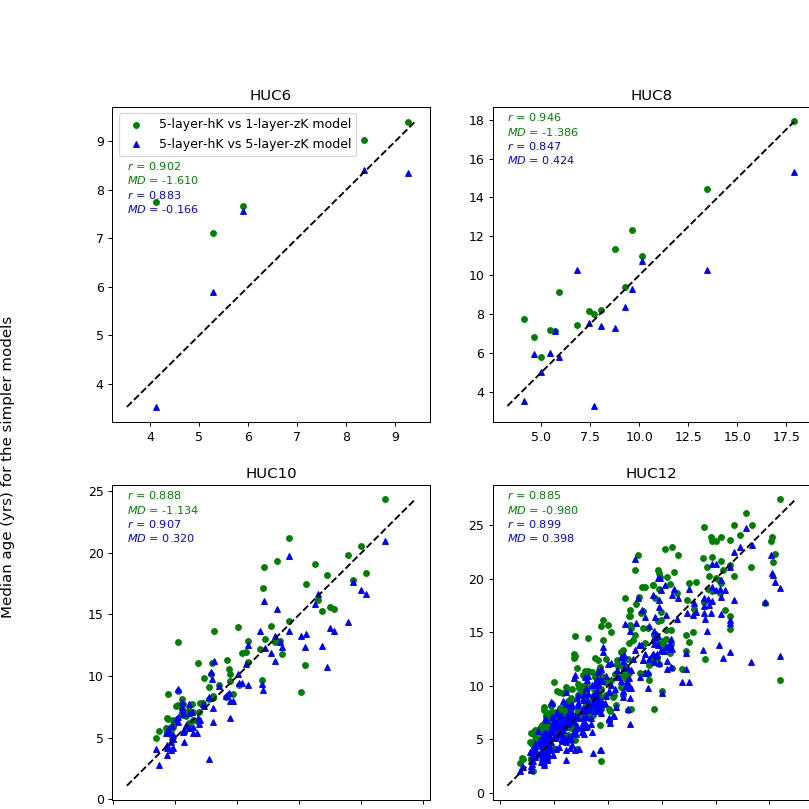

<IPython.core.display.Javascript object>


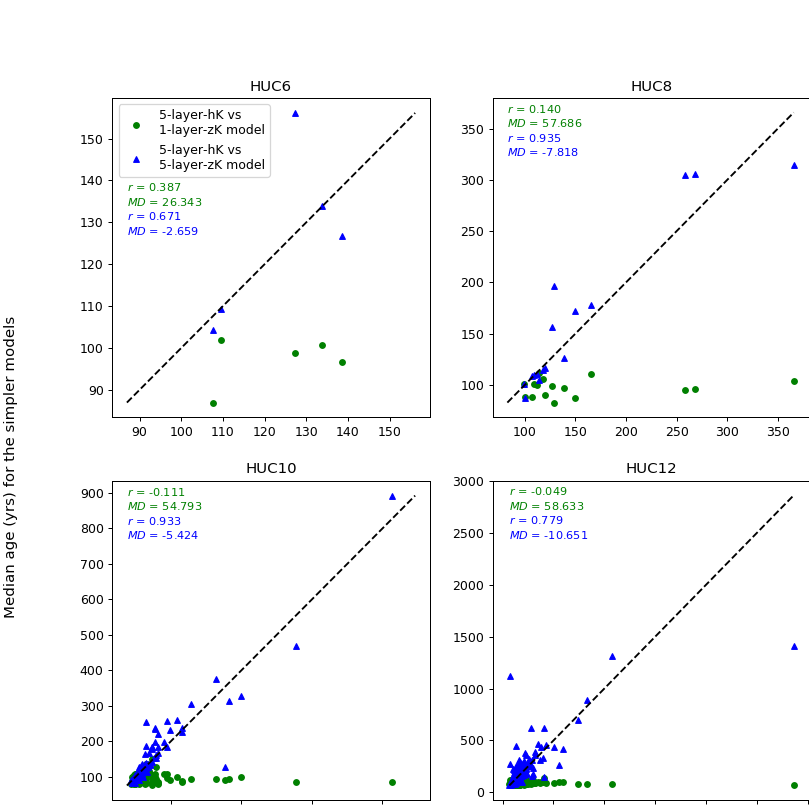

In [43]:
# 1:1 plot of meanYoungAge and meanOldAge btwn 5LhK against 1L and 5LzK models for ALL HUC scales.

hucs = ['HUC6', 'HUC8', 'HUC10', 'HUC12']
nhucs = len(hucs)
fig1, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig2, [[ax5, ax6], [ax7, ax8]] = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
youngaxisdict = {0:ax1, 1:ax2, 2:ax3, 3:ax4}
oldaxisdict = {0:ax5, 1:ax6, 2:ax7, 3:ax8}

for k, each in enumerate(hucs):
    # make sure we get ALL unique HUC IDs
    u1 = dfdict[eptlist[0]][each].unique()
    u2 = dfdict[eptlist[1]][each].unique()
    u3 = dfdict[eptlist[2]][each].unique()
    u = np.append(u1, u2)
    u = np.append(u, u3)
    uniques = np.unique(u)
    # remove any HUCs listed in purge_hucs
    for h in purge_hucs:
        ind = np.where(uniques==h)
        uniques = np.delete(uniques, ind)
    youngaxis = youngaxisdict[k]
    oldaxis = oldaxisdict[k]
    ofhucdict = {}
    yfhucdict = {}
    yfvalues = []
    ofvalues = []
    skiphuc = []
    for j, cat_val in enumerate(uniques):  # each HUC ID
        yfmoddict = {} 
        ofmoddict = {} 
        for i, md in enumerate(eptlist):  # each of the 3 FWP models
            mn = modlist[i]
            df = dfdict[md].loc[dfdict[md][each]==cat_val]
            if df.rt.count() >= minptl:
                youngdf = df.loc[df.rt < age_cutoff]
                olddf = df.loc[df.rt >= age_cutoff]
                yfage = youngdf.rt.median()
                ofage = olddf.rt.median()
                yfmoddict[mn] = yfage
                yfvalues.append(yfage) 
                ofmoddict[mn] = ofage
                ofvalues.append(ofage)
                '''
                # pull out raw time info for generalized model areas for later use...
                if (cat_val == float(genHUCdict['Oconto'])) and ('fwp5lzk' in mn):  # 5lzK is the most similar to Generalized models
                    FWPzKocontoDF = df.copy()
                #elif cat_val == float(genHUCdict['TWR'])  and (md == 'fwp5lzk'):
                elif cat_val == float(genHUCdict['TWR'])  and ('fwp5lzk' in mn):
                    FWPzKtwrDF = df.copy()
                elif (cat_val == float(genHUCdict['Oconto'])) and ('fwp5lhk' in mn):  # 5lzK is the most similar to Generalized models
                    FWPhKocontoDF = df.copy()
                elif cat_val == float(genHUCdict['TWR'])  and ('fwp5lhk' in mn):
                    FWPhKtwrDF = df.copy()
                elif (cat_val == float(genHUCdict['Oconto'])) and ('fwp1l' in mn):  # 5lzK is the most similar to Generalized models
                    FWP1locontoDF = df.copy()
                elif cat_val == float(genHUCdict['TWR'])  and ('fwp1l' in mn):
                    FWP1ltwrDF = df.copy()    
                '''
            else:
                skiphuc.append(cat_val)
                break
        if cat_val not in skiphuc:
            yfhucdict[cat_val] = yfmoddict
            ofhucdict[cat_val] = ofmoddict            
            
    young = pd.DataFrame(yfhucdict).T
    old = pd.DataFrame(ofhucdict).T
    for n in modlist:
        young = young.loc[~young[n].isnull()]  # need to remove any NANs
        old = old.loc[~old[n].isnull()]  # need to remove any NANs
        young['mYage_{}'.format(n)] = young[n]
        young['mYage_{}'.format(n)] = young[n]
    r2_y1y = r2_score(np.array(young[x1]), np.array(young[y1]))
    r2_y2y = r2_score(np.array(young[x1]), np.array(young[y2]))
    r2_y1o = r2_score(np.array(old[x1]), np.array(old[y1]))
    r2_y2o = r2_score(np.array(old[x1]), np.array(old[y2]))
    Prho_y1y, Pp_y1y = stats.pearsonr(np.array(young[x1]), np.array(young[y1]))
    Srho_y1y, Sp_y1y = stats.spearmanr(np.array(young[x1]), np.array(young[y1]))
    Prho_y2y, Pp_y2y = stats.pearsonr(np.array(young[x1]), np.array(young[y2]))
    Srho_y2y, Sp_y2y = stats.spearmanr(np.array(young[x1]), np.array(young[y2]))
    Prho_y1o, Pp_y1o = stats.pearsonr(np.array(old[x1]), np.array(old[y1]))
    Srho_y1o, Sp_y1o = stats.spearmanr(np.array(old[x1]), np.array(old[y1]))
    Prho_y2o, Pp_y2o = stats.pearsonr(np.array(old[x1]), np.array(old[y2]))
    Srho_y2o, Sp_y2o = stats.spearmanr(np.array(old[x1]), np.array(old[y2]))
    
    std_y1y = stats.tstd(np.array(young[x1]) - np.array(young[y1]))
    ME_y1y = np.mean(np.array(young[x1]) - np.array(young[y1]))
    std_y2y = stats.tstd(np.array(young[x1]) - np.array(young[y2]))
    ME_y2y = np.mean(np.array(young[x1]) - np.array(young[y2]))
    std_y1o = stats.tstd(np.array(old[x1]) - np.array(old[y1]))
    ME_y1o = np.mean(np.array(old[x1]) - np.array(old[y1]))
    std_y2o = stats.tstd(np.array(old[x1]) - np.array(old[y2]))
    ME_y2o = np.mean(np.array(old[x1]) - np.array(old[y2]))    
    
    #plotting
    miny, maxy = min(yfvalues), max(yfvalues)
    mino, maxo = min(ofvalues), max(ofvalues)
    yrange_y = maxy-miny
    yrange_o = maxo-mino
    
    if k == 0:
        young.plot(kind='scatter', x=x1, y=y1, marker='o', color='green', label='5-layer-hK vs 1-layer-zK model', ax=youngaxis)
        young.plot(kind='scatter', x=x1, y=y2, marker='^', color='blue', label = '5-layer-hK vs 5-layer-zK model', ax=youngaxis)        
        old.plot(kind='scatter', x=x1, y=y1, marker='o', color='green', label='5-layer-hK vs \n1-layer-zK model', ax=oldaxis)
        old.plot(kind='scatter', x=x1, y=y2, marker='^', color='blue', label = '5-layer-hK vs \n5-layer-zK model', ax=oldaxis)  
        #youngaxis.text(miny, miny+0.83*yrange_y, 'R2 = {:3.3f}'.format(r2_y1y), fontsize=9, color='green')
        #youngaxis.text(miny, miny+0.78*yrange_y, 'R2 = {:3.3f}'.format(r2_y2y), fontsize=9, color='blue')
        #oldaxis.text(mino, mino+0.83*yrange_o, 'R2 = {:3.3f}'.format(r2_y1o), fontsize=9, color='green')
        #oldaxis.text(mino, mino+0.78*yrange_o, 'R2 = {:3.3f}'.format(r2_y2o), fontsize=9, color='blue')
        youngaxis.text(miny, miny+0.83*yrange_y, r'$r$ = {:3.3f}'.format(Prho_y1y), fontsize=9, color='green')
        #youngaxis.text(miny, miny+0.78*yrange_y, r'$r_s$ = {:3.3f}'.format(Srho_y1y), fontsize=9, color='green')
        #youngaxis.text(miny, miny+0.73*yrange_y, r'$std$ = {:3.3f}'.format(std_y1y), fontsize=9, color='green')
        youngaxis.text(miny, miny+0.78*yrange_y, r'$MD$ = {:3.3f}'.format(ME_y1y), fontsize=9, color='green')
        youngaxis.text(miny, miny+0.73*yrange_y, r'$r$ = {:3.3f}'.format(Prho_y2y), fontsize=9, color='blue')
        #youngaxis.text(miny, miny+0.63*yrange_y, r'$r_s$ = {:3.3f}'.format(Srho_y2y), fontsize=9, color='blue')
        #youngaxis.text(miny, miny+0.53*yrange_y, r'$std$ = {:3.3f}'.format(std_y2y), fontsize=9, color='blue')
        youngaxis.text(miny, miny+0.68*yrange_y, r'$MD$ = {:3.3f}'.format(ME_y2y), fontsize=9, color='blue')
        
        oldaxis.text(mino, mino+0.73*yrange_o, r'$r$ = {:3.3f}'.format(Prho_y1o), fontsize=9, color='green')
        #oldaxis.text(mino, mino+0.78*yrange_o, r'$r_s$ = {:3.3f}'.format(Srho_y1o), fontsize=9, color='green')
        #oldaxis.text(mino, mino+0.73*yrange_o, r'$std$ = {:3.3f}'.format(std_y1o), fontsize=9, color='green')
        oldaxis.text(mino, mino+0.68*yrange_o, r'$MD$ = {:3.3f}'.format(ME_y1o), fontsize=9, color='green')
        oldaxis.text(mino, mino+0.63*yrange_o, r'$r$ = {:3.3f}'.format(Prho_y2o), fontsize=9, color='blue')
        #oldaxis.text(mino, mino+0.63*yrange_o, r'$r_s$ = {:3.3f}'.format(Srho_y2o), fontsize=9, color='blue')       
        #oldaxis.text(mino, mino+0.53*yrange_o, r'$std$ = {:3.3f}'.format(std_y2o), fontsize=9, color='blue')
        oldaxis.text(mino, mino+0.58*yrange_o, r'$MD$ = {:3.3f}'.format(ME_y2o), fontsize=9, color='blue')        
    else:
        young.plot(kind='scatter', x=x1, y=y1, marker='o', color='green', ax=youngaxis)
        young.plot(kind='scatter', x=x1, y=y2, marker='^', color='blue', ax=youngaxis)
        old.plot(kind='scatter', x=x1, y=y1, marker='o', color='green', ax=oldaxis)
        old.plot(kind='scatter', x=x1, y=y2, marker='^', color='blue', ax=oldaxis)     
        #youngaxis.text(miny, miny+yrange_y, 'R2 = {:3.3f}'.format(r2_y1y), fontsize=9, color='green')
        #youngaxis.text(miny, miny+0.95*yrange_y, 'R2 = {:3.3f}'.format(r2_y2y), fontsize=9, color='blue')
        #oldaxis.text(mino, mino+yrange_o, 'R2 = {:3.3f}'.format(r2_y1o), fontsize=9, color='green')
        #oldaxis.text(mino, mino+0.95*yrange_o, 'R2 = {:3.3f}'.format(r2_y2o), fontsize=9, color='blue')
        youngaxis.text(miny, miny+yrange_y, r'$r$ = {:3.3f}'.format(Prho_y1y), fontsize=9, color='green')
        #youngaxis.text(miny, miny+0.95*yrange_y, r'$r_s$ = {:3.3f}'.format(Srho_y1y), fontsize=9, color='green')
        #youngaxis.text(miny, miny+0.90*yrange_y, r'$std$ = {:3.3f}'.format(std_y1y), fontsize=9, color='green')
        youngaxis.text(miny, miny+0.95*yrange_y, r'$MD$ = {:3.3f}'.format(ME_y1y), fontsize=9, color='green')
        youngaxis.text(miny, miny+0.90*yrange_y, r'$r$ = {:3.3f}'.format(Prho_y2y), fontsize=9, color='blue')
        #youngaxis.text(miny, miny+0.80*yrange_y, r'$r_s$ = {:3.3f}'.format(Srho_y2y), fontsize=9, color='blue')
        #youngaxis.text(miny, miny+0.70*yrange_y, r'$std$ = {:3.3f}'.format(std_y2y), fontsize=9, color='blue')
        youngaxis.text(miny, miny+0.85*yrange_y, r'$MD$ = {:3.3f}'.format(ME_y2y), fontsize=9, color='blue')
        
        oldaxis.text(mino, mino+yrange_o, r'$r$ = {:3.3f}'.format(Prho_y1o), fontsize=9, color='green')
        #oldaxis.text(mino, mino+0.95*yrange_o, r'$r_s$ = {:3.3f}'.format(Srho_y1o), fontsize=9, color='green')
        #oldaxis.text(mino, mino+0.90*yrange_o, r'$std$ = {:3.3f}'.format(std_y1o), fontsize=9, color='green')
        oldaxis.text(mino, mino+0.95*yrange_o, r'$MD$ = {:3.3f}'.format(ME_y1o), fontsize=9, color='green')
        oldaxis.text(mino, mino+0.90*yrange_o, r'$r$ = {:3.3f}'.format(Prho_y2o), fontsize=9, color='blue')
        #oldaxis.text(mino, mino+0.80*yrange_o, r'$r_s$ = {:3.3f}'.format(Srho_y2o), fontsize=9, color='blue')
        #oldaxis.text(mino, mino+0.70*yrange_o, r'$std$ = {:3.3f}'.format(std_y2o), fontsize=9, color='blue')
        oldaxis.text(mino, mino+0.85*yrange_o, r'$MD$ = {:3.3f}'.format(ME_y2o), fontsize=9, color='blue')         
        
    youngaxis.plot((miny, maxy), (miny, maxy), 'k--')
    oldaxis.plot((mino, maxo), (mino, maxo), 'k--')

    youngaxis.set_xlabel(''), youngaxis.set_ylabel(''), oldaxis.set_xlabel(''), oldaxis.set_ylabel('')
    youngaxis.set_title(each)
    oldaxis.set_title(each)
    
    # Add an attribute to the HUC shapefile
    shapefile = HUCshpdict[each]
    shp = gpd.read_file(shapefile)  
    shp[each] = shp[each].astype('int64')  # convert so can merge
    
    young.index = young.index.astype('int64')  # convert so can merge
    young['mYage_hK-1L'] = young[x1] - young[y1]
    young['mYage_hK-zK'] = young[x1] - young[y2]
    df = pd.merge(shp, young, how='outer', left_on=each, right_index=True)
    dst = shapefile[:-4] + '_mYage.shp'
    df.to_file(dst)
    
    old.index = old.index.astype('int64')  # convert so can merge
    old['mOage_hK-1L'] = old[x1] - old[y1]
    old['mOage_hK-zK'] = old[x1] - old[y2]
    dfo = pd.merge(shp, old, how='outer', left_on=each, right_index=True)
    dsto = shapefile[:-4] + '_mOage.shp'
    dfo.to_file(dsto)

#fig1.text(0.46, 0.92, 'Young fraction', fontsize=12)
#fig2.text(0.48, 0.92, 'Old fraction', fontsize=12)
fig1.text(0.5, 0.055, 'Median age (yrs) for the complex (5-layer-hK) model', ha='center', fontsize=12)
fig1.text(0.001, 0.48, 'Median age (yrs) for the simpler models', va='center', fontsize=12, rotation='vertical')
fig2.text(0.5, 0.055, 'Median age (yrs) for the complex (5-layer-hK) model', ha='center', fontsize=12)
fig2.text(0.005, 0.48, 'Median age (yrs) for the simpler models', va='center', fontsize=12, rotation='vertical')
plt.subplots_adjust(top = .89)
#fig1.suptitle('Comparison of median ages for young fraction in the glacial aquifer by HUCs', fontsize=16)
#fig2.suptitle('Comparison of median ages for old fraction in the glacial aquifer by HUCs', fontsize=16)

# add background color
#youngrect = patches.Rectangle((200,70), 760, 830, zorder=-1, alpha=0.5, facecolor='b')
#oldrect = patches.Rectangle((960,70), 780, 830, zorder=-1, alpha=0.5, facecolor='r')
#fig.patches.append(youngrect)
#fig.patches.append(oldrect)

dst1 = 'Yages_121_allHUCs'
dst2 = 'Oages_121_allHUCs'
#loc = os.path.dirname(path[modlist[0]])  # go up one directory to the dir that houses all of the models.
#dst_pth = os.path.join(loc, dst)
dst_pth1 = os.path.join(fig_dir, dst1)
dst_pth2 = os.path.join(fig_dir, dst2)
fig1.savefig(dst_pth1)
fig2.savefig(dst_pth2)
#plt.close()

### The similar rho values for the YF-age results for both 1L and 5L (except old) above lead to the question:  Does BR or hK have more effect on differences in YF-age?  That is, is 5L_zK more like 1L_zK or more like 5L_hK??

<IPython.core.display.Javascript object>


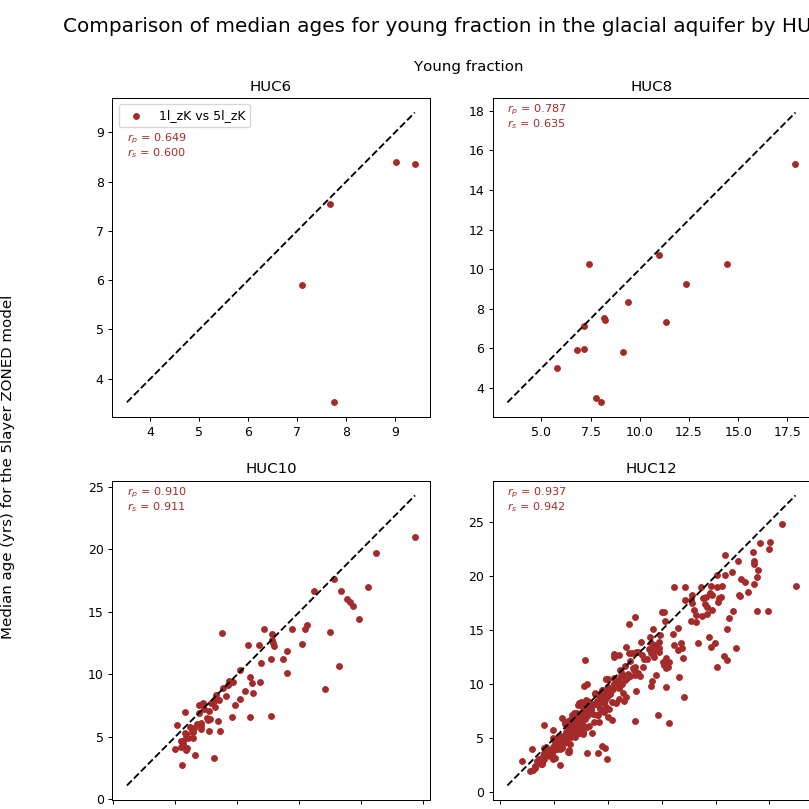

Text(0.5,0.98,'Comparison of median ages for young fraction in the glacial aquifer by HUCs')

In [19]:
# 1:1 plot of medYoungAge for 1LzK against 5LzK model for ALL HUC scales.

# for this plot only
localx1, localy1 = 'FWP1L_zK', 'FWP5L_zK'

hucs = ['HUC6', 'HUC8', 'HUC10', 'HUC12']
nhucs = len(hucs)
fig1, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
youngaxisdict = {0:ax1, 1:ax2, 2:ax3, 3:ax4}

for k, each in enumerate(hucs):
    # make sure we get ALL unique HUC IDs
    u1 = dfdict[eptlist[0]][each].unique()
    u2 = dfdict[eptlist[1]][each].unique()
    u3 = dfdict[eptlist[2]][each].unique()
    u = np.append(u1, u2)
    u = np.append(u, u3)
    uniques = np.unique(u)
    # remove any HUCs listed in purge_hucs
    for h in purge_hucs:
        ind = np.where(uniques==h)
        uniques = np.delete(uniques, ind)
    youngaxis = youngaxisdict[k]
    yfhucdict = {}
    yfvalues = []
    skiphuc = []
    for j, cat_val in enumerate(uniques):  # each HUC ID
        yfmoddict = {} 
        for i, md in enumerate(eptlist):  # each of the 3 FWP models
            mn = modlist[i]
            df = dfdict[md].loc[dfdict[md][each]==cat_val]
            if df.rt.count() >= minptl:
                youngdf = df.loc[df.rt < age_cutoff]
                yfage = youngdf.rt.median()
                yfmoddict[mn] = yfage
                yfvalues.append(yfage)                  
            else:
                skiphuc.append(cat_val)
                break
        if cat_val not in skiphuc:
            yfhucdict[cat_val] = yfmoddict
            
    young = pd.DataFrame(yfhucdict).T
    for n in modlist:
        young = young.loc[~young[n].isnull()]  # need to remove any NANs
    #r2_y1y = r2_score(np.array(young[localx1]), np.array(young[localy1]))
    Prho_y1, Pp_y1 = stats.pearsonr(np.array(young[localx1]), np.array(young[localy1]))
    Srho_y1, Sp_y1 = stats.spearmanr(np.array(young[localx1]), np.array(young[localy1]))
    
    #plotting
    miny, maxy = min(yfvalues), max(yfvalues)
    yrange_y = maxy-miny
    
    if k == 0:
        young.plot(kind='scatter', x=localx1, y=localy1, marker='o', color='brown', label='1l_zK vs 5l_zK', ax=youngaxis)       
        youngaxis.text(miny, miny+0.9*yrange_y, r'$r_p$ = {:3.3f}'.format(Prho_y1), fontsize=9, color='brown')
        youngaxis.text(miny, miny+0.85*yrange_y, r'$r_s$ = {:3.3f}'.format(Srho_y1), fontsize=9, color='brown')

    else:
        young.plot(kind='scatter', x=localx1, y=localy1, marker='o', color='brown', ax=youngaxis)
        youngaxis.text(miny, miny+yrange_y, r'$r_p$ = {:3.3f}'.format(Prho_y1), fontsize=9, color='brown')
        youngaxis.text(miny, miny+0.95*yrange_y, r'$r_s$ = {:3.3f}'.format(Srho_y1), fontsize=9, color='brown')
        
    youngaxis.plot((miny, maxy), (miny, maxy), 'k--')

    youngaxis.set_xlabel(''), youngaxis.set_ylabel('')
    youngaxis.set_title(each)

fig1.text(0.46, 0.92, 'Young fraction', fontsize=12)
fig1.text(0.5, 0.055, 'Median age (yrs) for the 1layer model', ha='center', fontsize=12)
fig1.text(0.001, 0.48, 'Median age (yrs) for the 5layer ZONED model', va='center', fontsize=12, rotation='vertical')
plt.subplots_adjust(top = .89)
fig1.suptitle('Comparison of median ages for young fraction in the glacial aquifer by HUCs', fontsize=16)

#### Comparing these rho values with those above for 5LhK versus 5LzK (blue), it seems that at regional scales (HUC 6 & 8) the two 5-layer models are more similar than the two zoned models (including BR is more important).  At finer scales (HUC 10 & 12), it may be the opposite (r and rho btwn the 5Ls is slightly lower than btwn the 2 zoned models at both HUC10 and HUC 12 scales).   Why is this?  Might consider computing the slope of each regession line to highlight the biased relationship for the 2 zoned models (https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.lstsq.html), but...  What is the larger implication (does anyone care; what does it mean)?  

#### I'm not sure it means all that much.  This could stem from non-linear drivers (BCs) that are too hard to decipher and the rho values are so close that it's hard to suggest a critical difference.

In [ ]:
# 1:1 plot of YOUNG FRACTION btwn 5LhK and 5LzK models for all HUC scales; color coded by differences in parameter
# values among the 5LhK and 5LzK models.  What's causing the age differences?

metric = 'mean'  # summary stat of the TIFF parameter.  valid entries:  'mean',  min', 'max', 'range', 'std'

hucs = ['HUC6', 'HUC8', 'HUC10', 'HUC12']
nhucs = len(hucs)

# loop this thing
for prop in HUCproprastlist:
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
    axisdict = {0:ax1, 1:ax2, 2:ax3, 3:ax4}
    
    for k, each in enumerate(hucs):
        # make sure we get ALL unique HUC IDs
        u1 = dfdict[eptlist[0]][each].unique()
        u2 = dfdict[eptlist[1]][each].unique()
        u3 = dfdict[eptlist[2]][each].unique()
        u = np.append(u1, u2)
        u = np.append(u, u3)
        uniques = np.unique(u)
        # remove any HUCs listed in purge_hucs
        for h in purge_hucs:
            ind = np.where(uniques==h)
            uniques = np.delete(uniques, ind)
        axis = axisdict[k]

        yfhucdict = {}
        yfvalues = []
        skiphuc = []
        for j, cat_val in enumerate(uniques.astype('int64')):  # each HUC ID
            yfmoddict = {}
            for i, md in enumerate(eptlist):  # each of the 3 FWP models
                mn = modlist[i]
                df = dfdict[md].loc[dfdict[md][each]==cat_val]
                if df.rt.count() >= minptl:
                    youngdf = df.loc[df.rt < age_cutoff]
                    yf = youngdf.rt.count() / df.rt.count()
                    yfmoddict[mn] = yf
                    yfvalues.append(yf)
                else:
                    skiphuc.append(cat_val)
                    break
            if cat_val not in skiphuc:
                yfhucdict[cat_val] = yfmoddict    

        ddd = pd.DataFrame(yfhucdict).T
        for n in modlist:
            ddd = ddd.loc[~ddd[n].isnull()]  # need to remove any NANs

        print('Extracting zonal summary values from {} for {}'.format(prop, each))
        # run zonal_stats on the merged df. Use the 'HUC' Tiffs to match up with model properties
        raster_file = HUCtiffdict[each]
        with rasterio.open(raster_file) as raster:
            hucrast = raster.read()[0]
        with rasterio.open(prop) as raster:
            proprast = raster.read()[0]

        prprty = os.path.basename(prop).split('.')[0]   # type of info in the rasters
        descript1 = '{}_{}'.format(metric, prprty)
        ddd2 = hucpropstats2(hucrast, proprast, ddd, raster_file, metric, descript1)
        ddd2 = ddd2.loc[ddd2[descript1].notnull()]  # remove any NANs
        mod1 = abrevdict[x1]
        mod2 = abrevdict[y2]
        mod_compr = mod1 + '-' + mod2
    
        # Need to write the difference between 5hK and 5zK to the DF so can compute correlation to drivers (prop tiffs)
        ddd2[mod_compr] = ddd2[x1] - ddd2[y2]  # age or YF difference
        # Compute r, or rho, for the color flood.  That is, r for the property vs difference in age
        Srho_color, Sp_color = stats.spearmanr(np.array(ddd2[descript1]), np.array(ddd2[mod_compr]))
        Prho_color, Pp_color = stats.pearsonr(np.array(ddd2[descript1]), np.array(ddd2[mod_compr]))
        std_color = stats.tstd(np.array(ddd2[descript1]) - np.array(ddd2[mod_compr]))
        ME_color = np.mean(np.array(ddd2[descript1]) - np.array(ddd2[mod_compr]))
        
        print('Preparing plots for {}'.format(each))
        mini = min(min(ddd2[evaluate[0]]), min(ddd2[evaluate[1]]))
        maxi = max(max(ddd2[evaluate[0]]), max(ddd2[evaluate[1]]))
        yrange = maxi-mini
        norm = MidpointNormalize(midpoint=0)
        ddd2.plot(kind='scatter', x=x1, y=y2, marker='^', c=ddd2[descript1], cmap='RdYlBu', norm=norm, ax=axis, vmax=ddd2[descript1].quantile(.99), vmin=ddd2[descript1].quantile(.01))
        lowlim = min(axis.get_xlim()[0], axis.get_ylim()[0])
        uplim = max(axis.get_xlim()[1], axis.get_ylim()[1])
        lims = (lowlim, uplim)
        lrange = uplim - lowlim
        axis.set_xlim(lims)  # force the plots to be square
        axis.set_ylim(lims)  
        axis.text(lowlim+0.03*lrange, uplim-0.11*lrange, 'Fit metrics between model property \nand median YFage differences:', fontsize=9)
        axis.text(lowlim+0.03*lrange, uplim-0.16*lrange, r'$r_p$ = {:3.3f}'.format(Prho_color), fontsize=9)
        axis.text(lowlim+0.03*lrange, uplim-0.21*lrange, r'$r_s$ = {:3.3f}'.format(Srho_color), fontsize=9)
        axis.text(lowlim+0.03*lrange, uplim-0.26*lrange, r'$std$ = {:3.3f}'.format(std_color), fontsize=9)
        axis.text(lowlim+0.03*lrange, uplim-0.31*lrange, r'$ME$ = {:3.3f}'.format(ME_color), fontsize=9)
        pos1 = axis.get_position()
        axis.plot((mini, maxi), (mini, maxi), 'k--')
        axis.annotate("", xy=(mini+0.32*yrange, maxi-0.35*yrange), xytext=(mini+0.48*yrange, mini+0.52*yrange), arrowprops=dict(arrowstyle="->", lw=3, color='gray', alpha=0.3))  # orange
        axis.annotate("", xy=(maxi-0.32*yrange, mini+0.35*yrange), xytext=(mini+0.52*yrange, mini+0.48*yrange), arrowprops=dict(arrowstyle="->", lw=3, color='gray', alpha=0.3))  # royalblue
        axis.set_xlabel(''), axis.set_ylabel('')
        axis.set_title(each)

    fig.text(0.5, 0.105, 'Young Fraction for the 5-layer-hK model', ha='center', fontsize=12)
    fig.text(0.07, 0.48, 'Young Fraction for the 5-layer-zK model', va='center', fontsize=12, rotation='vertical')
    plt.subplots_adjust(top = .86, bottom = 0.15)
    mod_factor = os.path.basename(prop).split('.')[0]
    #fig.suptitle('Comparison of Young Fractions by HUC scale,\n as informed by model '
    #             'property:  {} of {}'.format(metric, prprty), fontsize=16)

    dst = '5L_YFCompare_by_{}_of_{}.png'.format(metric, prprty)
    dst_pth = os.path.join(fig_dir, dst)
    f = plt.gcf()
    f.savefig(dst_pth)
#f.close()
#fig.close()

# Add an attribute to the HUC shapefile
shapefile = HUCshpdict[each]
path = os.path.dirname(HUCshpdict[each])
shp = gpd.read_file(shapefile)  
shp[each] = shp[each].astype('int64')  # convert so can merge

ddd2.index = ddd2.index.astype('int64')  # convert so can merge
df = pd.merge(shp, ddd2, how='outer', left_on=each, right_index=True)
dst = os.path.join(path, '{}_YF_{}_{}.shp'.format(each, metric, prprty))
df.to_file(dst)

In [ ]:
# 1:1 plot of meanYoungAge btwn 5LhK and 5LzK models for all HUC scales; color coded by differences in parameter
# values among the 5LhK and 5LzK models.  What's causing the age differences?

metric = 'mean'  # summary stat of the TIFF parameter.  valid entries:  'mean',  min', 'max', 'range', 'std'

hucs = ['HUC6', 'HUC8', 'HUC10', 'HUC12']
nhucs = len(hucs)

# loop this thing
for prop in HUCproprastlist:
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
    axisdict = {0:ax1, 1:ax2, 2:ax3, 3:ax4}
    
    for k, each in enumerate(hucs):
        # make sure we get ALL unique HUC IDs
        u1 = dfdict[eptlist[0]][each].unique()
        u2 = dfdict[eptlist[1]][each].unique()
        u3 = dfdict[eptlist[2]][each].unique()
        u = np.append(u1, u2)
        u = np.append(u, u3)
        uniques = np.unique(u)
        # remove any HUCs listed in purge_hucs
        for h in purge_hucs:
            ind = np.where(uniques==h)
            uniques = np.delete(uniques, ind)
        axis = axisdict[k]

        yfhucdict = {}
        yfvalues = []
        skiphuc = []
        for j, cat_val in enumerate(uniques.astype('int64')):  # each HUC ID
            yfmoddict = {}
            for i, md in enumerate(eptlist):  # each of the 3 FWP models
                mn = modlist[i]
                df = dfdict[md].loc[dfdict[md][each]==cat_val]
                if df.rt.count() >= minptl:
                    youngdf = df.loc[df.rt < age_cutoff]
                    yfage = youngdf.rt.median()
                    yfmoddict[mn] = yfage
                    yfvalues.append(yfage)
                else:
                    skiphuc.append(cat_val)
                    break
            if cat_val not in skiphuc:
                yfhucdict[cat_val] = yfmoddict    

        ddd = pd.DataFrame(yfhucdict).T
        for n in modlist:
            ddd = ddd.loc[~ddd[n].isnull()]  # need to remove any NANs

        print('Extracting zonal summary values from {} for {}'.format(prop, each))
        # run zonal_stats on the merged df. Use the 'HUC' Tiffs to match up with model properties
        raster_file = HUCtiffdict[each]
        with rasterio.open(raster_file) as raster:
            hucrast = raster.read()[0]
        with rasterio.open(prop) as raster:
            proprast = raster.read()[0]

        prprty = os.path.basename(prop).split('.')[0]   # type of info in the rasters
        descript1 = '{}_{}'.format(metric, prprty)
        ddd2 = hucpropstats2(hucrast, proprast, ddd, raster_file, metric, descript1)
        ddd2 = ddd2.loc[ddd2[descript1].notnull()]  # remove any NANs
        mod1 = abrevdict[x1]
        mod2 = abrevdict[y2]
        mod_compr = mod1 + '-' + mod2
    
        # Need to write the difference between 5hK and 5zK to the DF so can compute correlation to drivers (prop tiffs)
        ddd2[mod_compr] = ddd2[x1] - ddd2[y2]  # age or YF difference
        # Compute r, or rho, for the color flood.  That is, r for the property vs difference in age
        #r2_color = r2_score(np.array(ddd2[descript1]), np.array(ddd2[mod_compr]))
        Srho_color, Sp_color = stats.spearmanr(np.array(ddd2[descript1]), np.array(ddd2[mod_compr]))
        Prho_color, Pp_color = stats.pearsonr(np.array(ddd2[descript1]), np.array(ddd2[mod_compr]))
        std_color = stats.tstd(np.array(ddd2[descript1]) - np.array(ddd2[mod_compr]))
        ME_color = np.mean(np.array(ddd2[descript1]) - np.array(ddd2[mod_compr]))
        
        print('Preparing plots for {}'.format(each))
        #mini, maxi = min(yfvalues), max(yfvalues)
        #xplot = mini+(maxi-mini)/2
        #yrange = maxi-mini
        mini = min(min(ddd2[evaluate[0]]), min(ddd2[evaluate[1]]))
        maxi = max(max(ddd2[evaluate[0]]), max(ddd2[evaluate[1]]))
        yrange = maxi-mini
        norm = MidpointNormalize(midpoint=0)
        ddd2.plot(kind='scatter', x=x1, y=y2, marker='^', c=ddd2[descript1], cmap='RdYlBu', norm=norm, ax=axis, vmax=ddd2[descript1].quantile(.99), vmin=ddd2[descript1].quantile(.01))
        lowlim = min(axis.get_xlim()[0], axis.get_ylim()[0])
        uplim = max(axis.get_xlim()[1], axis.get_ylim()[1])
        lims = (lowlim, uplim)
        lrange = uplim - lowlim
        axis.set_xlim(lims)  # force the plots to be square
        axis.set_ylim(lims)  
        axis.text(lowlim+0.03*lrange, uplim-0.11*lrange, 'Fit metrics between model property \nand median YFage differences:', fontsize=9)
        axis.text(lowlim+0.03*lrange, uplim-0.16*lrange, r'$r_p$ = {:3.3f}'.format(Prho_color), fontsize=9)
        axis.text(lowlim+0.03*lrange, uplim-0.21*lrange, r'$r_s$ = {:3.3f}'.format(Srho_color), fontsize=9)
        axis.text(lowlim+0.03*lrange, uplim-0.26*lrange, r'$std$ = {:3.3f}'.format(std_color), fontsize=9)
        axis.text(lowlim+0.03*lrange, uplim-0.31*lrange, r'$ME$ = {:3.3f}'.format(ME_color), fontsize=9)
        pos1 = axis.get_position()
        axis.plot((mini, maxi), (mini, maxi), 'k--')
        axis.annotate("", xy=(mini+0.32*yrange, maxi-0.35*yrange), xytext=(mini+0.48*yrange, mini+0.52*yrange), arrowprops=dict(arrowstyle="->", lw=3, color='gray', alpha=0.3))  # orange
        axis.annotate("", xy=(maxi-0.32*yrange, mini+0.35*yrange), xytext=(mini+0.52*yrange, mini+0.48*yrange), arrowprops=dict(arrowstyle="->", lw=3, color='gray', alpha=0.3))  # royalblue
        axis.set_xlabel(''), axis.set_ylabel('')
        axis.set_title(each)
        axis.set_yticklabels(['{0:d}'.format(int(x)) for x in axis.get_yticks().tolist()])

    fig.text(0.5, 0.105, 'Median age (yrs) for the 5-layer variable K model', ha='center', fontsize=12)
    fig.text(0.07, 0.48, 'Median age (yrs) for the 5-layer zoned K model', va='center', fontsize=12, rotation='vertical')
    plt.subplots_adjust(top = .86, bottom = 0.15)
    mod_factor = os.path.basename(prop).split('.')[0]
    fig.suptitle('Comparison of median Glacial Young ages by HUC scale,\n as informed by model '
                 'property:  {} of {}'.format(metric, prprty), fontsize=16)

    dst = '5L_mYageCompare_by_{}_of_{}.png'.format(metric, prprty)
    dst_pth = os.path.join(fig_dir, dst)
    f = plt.gcf()
    f.savefig(dst_pth)
#f.close()
#fig.close()

# Add an attribute to the HUC shapefile
shapefile = HUCshpdict[each]
path = os.path.dirname(HUCshpdict[each])
shp = gpd.read_file(shapefile)  
shp[each] = shp[each].astype('int64')  # convert so can merge

ddd2.index = ddd2.index.astype('int64')  # convert so can merge
df = pd.merge(shp, ddd2, how='outer', left_on=each, right_index=True)
dst = os.path.join(path, '{}_mYage_{}_{}.shp'.format(each, metric, prprty))
df.to_file(dst)

###### There is some relationship between diff in model properites and diff in mYFage for some model properties (hK, R), but it tends to cluster at young ages.

# Figure 6  of the FWP comparison paper.  Last edited/generated 1/31/19

<IPython.core.display.Javascript object>


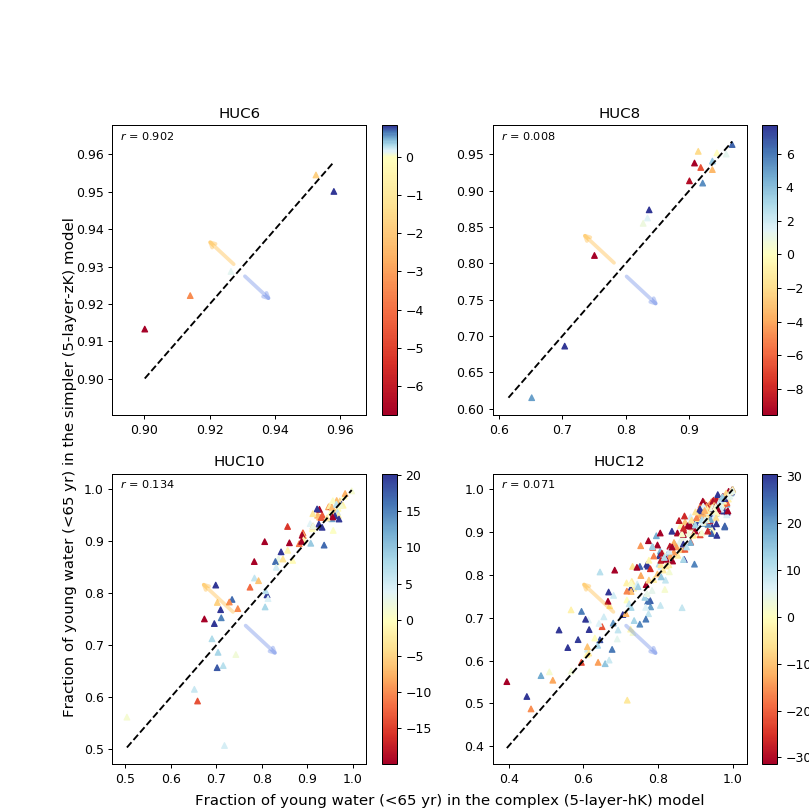

Processing HUCs for HUC6
Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRgain.tif for HUC6


C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in greater
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in less
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in greater
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in less
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\en

Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRgain.tif for HUC6
Preparing plots for HUC6
Processing HUCs for HUC8
Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRgain.tif for HUC8


C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\numpy\lib\function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: All-NaN slice encountered
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRgain.tif for HUC8
Preparing plots for HUC8
Processing HUCs for HUC10
Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRgain.tif for HUC10
Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRgain.tif for HUC10
Preparing plots for HUC10
Processing HUCs for HUC12
Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRgain.tif for HUC12
Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRgain.tif for HUC12
Preparing plots for HUC12


"\n# Add an attribute to the HUC shapefile\nshapefile = HUCshpdict[each]\npath = os.path.dirname(HUCshpdict[each])\nshp = gpd.read_file(shapefile)  \nshp[each] = shp[each].astype('int64')  # convert so can merge\n\nddd2.index = ddd2.index.astype('int64')  # convert so can merge\ndf = pd.merge(shp, ddd2, how='outer', left_on=each, right_index=True)\ndst = os.path.join(path, '{}_YF_{}_{}.shp'.format(each, fluxtype, metric))\ndf.to_file(dst)\n"

In [72]:
#### Process Flux result rasters differently
# 1:1 plot of YoungFraction btwn 5LhK and 5LzK models for all HUC scales; color coded by differences in model output
# among the 5LhK and 5LzK models.  What's causing the YF differences?

topic = 'net'  # Chose between 'discharge', 'seepage', or 'net.  Refers to dicts of tiffs for discharge to 
                        # SFR cells or SFR cells seeping into aquifers.  Net subtracts seepage from discharge before analyzing.
metric = 'mean'  # valid:  'mean', 'median', sum', min', 'max', 'range', 'std', 'count'

hucs = ['HUC6', 'HUC8', 'HUC10', 'HUC12']
nhucs = len(hucs)

# loop this thing
#for prop in HUCfluxrastlist:

#for Qkey, prop in dischargerastdict.items():
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axisdict = {0:ax1, 1:ax2, 2:ax3, 3:ax4}

for k, each in enumerate(hucs):
    # make sure we get ALL unique HUC IDs
    u1 = dfdict[eptlist[0]][each].unique()
    u2 = dfdict[eptlist[1]][each].unique()
    u3 = dfdict[eptlist[2]][each].unique()
    u = np.append(u1, u2)
    u = np.append(u, u3)
    uniques = np.unique(u)
    # remove any HUCs listed in purge_hucs
    for h in purge_hucs:
        ind = np.where(uniques==h)
        uniques = np.delete(uniques, ind)
    axis = axisdict[k]

    yfhucdict = {}
    yfvalues = []
    skiphuc = []
    for j, cat_val in enumerate(uniques.astype('int64')):  # each HUC ID
        yfmoddict = {}            
        for i, md in enumerate(eptlist):  # each of the 3 FWP models
            mn = modlist[i]
            df = dfdict[md].loc[dfdict[md][each]==cat_val]
            if df.rt.count() >= minptl:
                youngdf = df.loc[df.rt < age_cutoff]
                yf = youngdf.rt.count() / df.rt.count()
                yfmoddict[mn] = yf
                yfvalues.append(yf)
            else:
                skiphuc.append(cat_val)
                break
        if cat_val not in skiphuc:
            yfhucdict[cat_val] = yfmoddict    
    ddd = pd.DataFrame(yfhucdict).T
    for n in modlist:
        ddd = ddd.loc[~ddd[n].isnull()]  # need to remove any NANs
        
    # run zonal_stats on the merged df. Use the 'HUC' Tiffs to match up with model properties
    print('Processing HUCs for {}'.format(each))
    raster_file = HUCtiffdict[each]
    with rasterio.open(raster_file) as raster:
        hucrast = raster.read()[0]
        
    #Process the "evaluate rasters"
    for i in range(len(evaluate)):
        modnm = evaluate[i]
        if topic == 'discharge':
            prop = dischargerastdict[modnm]
            fluxtype = os.path.basename(prop).split('.')[0].split('_')[-1]  # type of info in the rasters
        elif topic == 'seepage':
            prop = lossrastdict[modnm]
            fluxtype = os.path.basename(prop).split('.')[0].split('_')[-1]  # type of info in the rasters
        elif topic == 'net':
            prop1 = dischargerastdict[modnm]
            prop2 = lossrastdict[modnm]
            fluxtype = 'Net' + os.path.basename(prop).split('.')[0].split('_')[-1]  # type of info in the rasters
        else:
            print('only "discharge", "seepage", or "net" are valid entries for the "topic" variable.  Stopping.')
            sys.exit()
            
        print('Extracting zonal summary values from {} for {}'.format(prop, each))
        if topic == 'discharge' or topic == 'seepage':
            with rasterio.open(prop) as raster:
                fluxrast = raster.read()[0]
                if np.nanmax(fluxrast) <= 0.0:  # convert all negative arrays to positive
                    fluxrast = fluxrast * -1
        else:
            with rasterio.open(prop1) as raster1:
                fluxrast1 = raster1.read()[0]
                if np.nanmax(fluxrast1) <= 0.0:  # convert all negative arrays to positive
                    fluxrast1 = fluxrast1 * -1
            with rasterio.open(prop2) as raster2:
                fluxrast2 = raster2.read()[0]
                if np.nanmax(fluxrast2) <= 0.0:  # convert all negative arrays to positive
                    fluxrast2 = fluxrast2 * -1
            fluxrast = fluxrast1 - fluxrast2  # all this finagling ensures that net discharge is positive.
                    
        if i == 0:
            mod_factor1 = abrevdict[modnm]
            descript1 = '{}_{}_{}'.format(metric, fluxtype, mod_factor1)
            firstflux = fluxrast.copy() 
            ddd1 = hucpropstats2(hucrast, firstflux, ddd, raster_file, metric, descript1) 
        elif i==1:
            mod_factor2 = abrevdict[modnm]
            descript2 = '{}_{}_{}'.format(metric, fluxtype, mod_factor2)
            # process second raster.
            ddd2 = hucpropstats2(hucrast, fluxrast, ddd1, raster_file, metric, descript2)
            fluxdiff = firstflux - fluxrast
            mod_factor3 = mod_factor1 + '-' + mod_factor2
            descript3 = '{}_{}_{}'.format(metric, fluxtype, mod_factor3)
            ddd2[descript3] = ddd2[descript1] - ddd2[descript2]
            descript4 = '%change_{}'.format(descript3)
            ddd2[descript4] = (ddd2[descript3] / ddd2[descript1]) * 100.0
            ddd2.replace([np.inf, -np.inf], np.nan)  # just in case infinity is calculated. Convert to nan before purge nan.
            ddd2 = ddd2.loc[ddd2[descript4].notnull()]  # remove any NANs
        else:
            print('Only 2 models were supposed to be listed in the EVALUATE variable.  Please fix that and re-run. Stopping.')
            sys.exit()
    
    print('Preparing plots for {}'.format(each))
    ddd2[mod_factor3] = ddd2[evaluate[0]] - ddd2[evaluate[1]]  # YF difference
    Srho_color, Sp_color = stats.spearmanr(np.array(ddd2[descript4]), np.array(ddd2[mod_factor3]))
    Prho_color, Pp_color = stats.pearsonr(np.array(ddd2[descript4]), np.array(ddd2[mod_factor3]))
    std_color = stats.tstd(np.array(ddd2[descript4]) - np.array(ddd2[mod_factor3]))
    ME_color = np.mean(np.array(ddd2[descript4]) - np.array(ddd2[mod_factor3]))
         
    #plotting
    mini = min(min(ddd2[evaluate[0]]), min(ddd2[evaluate[1]]))
    maxi = max(max(ddd2[evaluate[0]]), max(ddd2[evaluate[1]]))
    yrange = maxi-mini
    norm = MidpointNormalize(midpoint=0)
    ddd2.plot(kind='scatter', x=x1, y=y2, marker='^', c=ddd2[descript4], cmap='RdYlBu', norm=norm, ax=axis, vmax=ddd2[descript4].quantile(.90), vmin=ddd2[descript4].quantile(.1)) # 0.99 & 0.01 originally
    lowlim = min(axis.get_xlim()[0], axis.get_ylim()[0])
    uplim = max(axis.get_xlim()[1], axis.get_ylim()[1])
    lims = (lowlim, uplim)
    lrange = uplim - lowlim
    axis.set_xlim(lims)  # force the plots to be square
    axis.set_ylim(lims)
    #axis.text(lowlim+0.03*lrange, uplim-0.11*lrange, 'Fit metrics between model \nproperty and YF differences:', fontsize=9)
    #axis.text(lowlim+0.03*lrange, uplim-0.16*lrange, r'$r$ = {:3.3f}  $p$={:1.1e}'.format(Prho_color, Pp_color), fontsize=9)
    axis.text(lowlim+0.03*lrange, uplim-0.05*lrange, r'$r$ = {:3.3f}'.format(Prho_color), fontsize=9)
    #axis.text(lowlim+0.03*lrange, uplim-0.21*lrange, r'$r_s$ = {:3.3f}  $p$={:1.1e}'.format(Srho_color, Sp_color), fontsize=9)
    #axis.text(lowlim+0.03*lrange, uplim-0.26*lrange, r'$std$ = {:3.3f}'.format(std_color), fontsize=9)
    #axis.text(lowlim+0.03*lrange, uplim-0.26*lrange, r'$ME$ = {:3.3f}'.format(ME_color), fontsize=9)
    pos1 = axis.get_position()
    axis.plot((mini, maxi), (mini, maxi), 'k--')
    axis.annotate("", xy=(mini+0.32*yrange, maxi-0.35*yrange), xytext=(mini+0.48*yrange, mini+0.52*yrange), arrowprops=dict(arrowstyle="->", lw=3, color='royalblue', alpha=0.3))  # orange or gray
    axis.annotate("", xy=(maxi-0.32*yrange, mini+0.35*yrange), xytext=(mini+0.52*yrange, mini+0.48*yrange), arrowprops=dict(arrowstyle="->", lw=3, color='orange', alpha=0.3))  # royalblue
    axis.set_xlabel(''), axis.set_ylabel('')
    #axis.set_title(descript3)
    axis.set_title(each)  # HUC

fig.text(0.5, 0.105, 'Fraction of young water (<65 yr) in the complex (5-layer-hK) model', ha='center', fontsize=12)
fig.text(0.07, 0.48, 'Fraction of young water (<65 yr) in the simpler (5-layer-zK) model', va='center', fontsize=12, rotation='vertical')
plt.subplots_adjust(top = .86, bottom = 0.15)
#fig.suptitle('Comparison of Young Fraction by HUC scale, as informed by model \n'
#         'property:  %change in {} of {}'.format(metric, fluxtype), fontsize=16)

#dst = '5L_YFCompare_by_%del_{}_of_{}_of_{}.png'.format(metric, fluxtype, mod_factor3)
#dst_pth = os.path.join(fig_dir, dst)
#f = plt.gcf()
#f.savefig(dst_pth)
'''
# Add an attribute to the HUC shapefile
shapefile = HUCshpdict[each]
path = os.path.dirname(HUCshpdict[each])
shp = gpd.read_file(shapefile)  
shp[each] = shp[each].astype('int64')  # convert so can merge

ddd2.index = ddd2.index.astype('int64')  # convert so can merge
df = pd.merge(shp, ddd2, how='outer', left_on=each, right_index=True)
dst = os.path.join(path, '{}_YF_{}_{}.shp'.format(each, fluxtype, metric))
df.to_file(dst)
'''

<IPython.core.display.Javascript object>


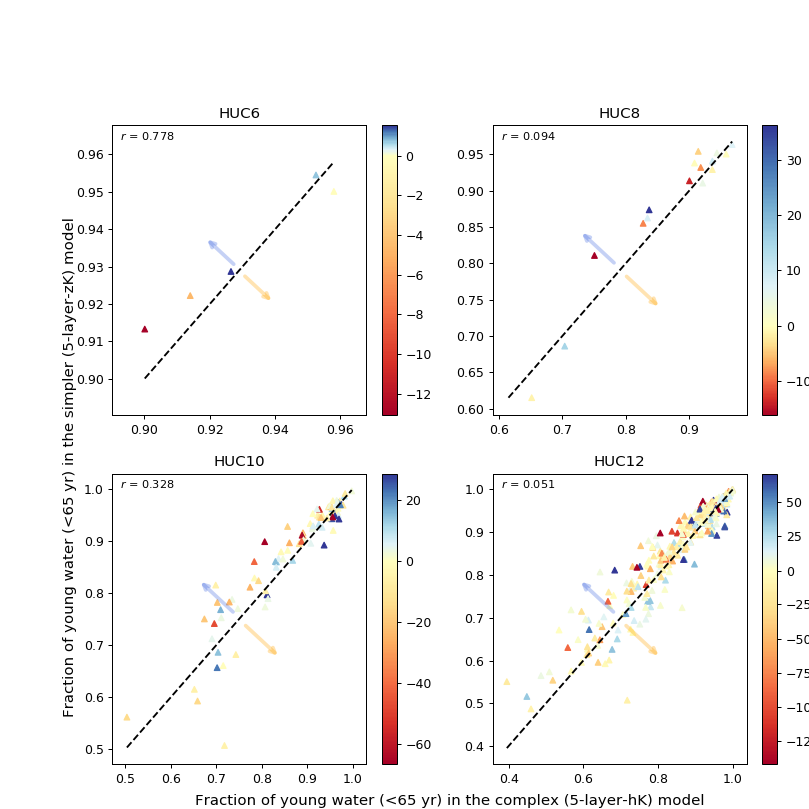

Processing HUCs for HUC6
Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRgain.tif for HUC6


C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in greater
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in less
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in greater
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in less
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\en

Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRgain.tif for HUC6
Preparing plots for HUC6
Processing HUCs for HUC8
Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRgain.tif for HUC8


C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\numpy\lib\function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: All-NaN slice encountered
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.


Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRgain.tif for HUC8
Preparing plots for HUC8
Processing HUCs for HUC10
Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRgain.tif for HUC10
Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRgain.tif for HUC10
Preparing plots for HUC10
Processing HUCs for HUC12
Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRgain.tif for HUC12
Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRgain.tif for HUC12
Preparing plots for HUC12


"\n# Add an attribute to the HUC shapefile\nshapefile = HUCshpdict[each]\npath = os.path.dirname(HUCshpdict[each])\nshp = gpd.read_file(shapefile)  \nshp[each] = shp[each].astype('int64')  # convert so can merge\n\nddd2.index = ddd2.index.astype('int64')  # convert so can merge\ndf = pd.merge(shp, ddd2, how='outer', left_on=each, right_index=True)\ndst = os.path.join(path, '{}_YF_{}_{}.shp'.format(each, fluxtype, metric))\ndf.to_file(dst)\n"

In [79]:
#### Process Flux result BASED ON STREAM ORDER
# 1:1 plot of YoungFraction btwn 5LhK and 5LzK models for all HUC scales; color coded by differences in model output
# among the 5LhK and 5LzK models.  What's causing the YF differences?
streamorder = 1
topic = 'net'  # Chose between 'discharge', 'seepage', or 'net.  Refers to dicts of tiffs for discharge to 
                        # SFR cells or SFR cells seeping into aquifers.  Net subtracts seepage from discharge before analyzing.
metric = 'mean'  # valid:  'mean', 'median', sum', min', 'max', 'range', 'std', 'count'

hucs = ['HUC6', 'HUC8', 'HUC10', 'HUC12']
nhucs = len(hucs)

# loop this thing
#for prop in HUCfluxrastlist:

#for Qkey, prop in dischargerastdict.items():
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axisdict = {0:ax1, 1:ax2, 2:ax3, 3:ax4}

for k, each in enumerate(hucs):
    # make sure we get ALL unique HUC IDs
    u1 = dfdict[eptlist[0]][each].unique()
    u2 = dfdict[eptlist[1]][each].unique()
    u3 = dfdict[eptlist[2]][each].unique()
    u = np.append(u1, u2)
    u = np.append(u, u3)
    uniques = np.unique(u)
    # remove any HUCs listed in purge_hucs
    for h in purge_hucs:
        ind = np.where(uniques==h)
        uniques = np.delete(uniques, ind)
    axis = axisdict[k]

    yfhucdict = {}
    yfvalues = []
    skiphuc = []
    for j, cat_val in enumerate(uniques.astype('int64')):  # each HUC ID
        yfmoddict = {}            
        for i, md in enumerate(eptlist):  # each of the 3 FWP models
            mn = modlist[i]
            df = dfdict[md].loc[dfdict[md][each]==cat_val]
            if df.rt.count() >= minptl:
                youngdf = df.loc[df.rt < age_cutoff]
                yf = youngdf.rt.count() / df.rt.count()
                yfmoddict[mn] = yf
                yfvalues.append(yf)
            else:
                skiphuc.append(cat_val)
                break
        if cat_val not in skiphuc:
            yfhucdict[cat_val] = yfmoddict    
    ddd = pd.DataFrame(yfhucdict).T
    for n in modlist:
        ddd = ddd.loc[~ddd[n].isnull()]  # need to remove any NANs
        
    # run zonal_stats on the merged df. Use the 'HUC' Tiffs to match up with model properties
    print('Processing HUCs for {}'.format(each))
    raster_file = HUCtiffdict[each]
    with rasterio.open(raster_file) as raster:
        hucrast = raster.read()[0]       
            
    #Process the "evaluate rasters"
    for i in range(len(evaluate)):
        modnm = evaluate[i]
        if topic == 'discharge':
            prop = dischargerastdict[modnm]
            fluxtype = os.path.basename(prop).split('.')[0].split('_')[-1]  # type of info in the rasters
        elif topic == 'seepage':
            prop = lossrastdict[modnm]
            fluxtype = os.path.basename(prop).split('.')[0].split('_')[-1]  # type of info in the rasters
        elif topic == 'net':
            prop1 = dischargerastdict[modnm]
            prop2 = lossrastdict[modnm]
            fluxtype = 'Net' + os.path.basename(prop).split('.')[0].split('_')[-1]  # type of info in the rasters
        else:
            print('only "discharge", "seepage", or "net" are valid entries for the "topic" variable.  Stopping.')
            sys.exit()
            
        print('Extracting zonal summary values from {} for {}'.format(prop, each))
        if topic == 'discharge' or topic == 'seepage':
            with rasterio.open(prop) as raster:
                fluxrast = raster.read()[0]
                if np.nanmax(fluxrast) <= 0.0:  # convert all negative arrays to positive
                    fluxrast = fluxrast * -1
        else:
            with rasterio.open(prop1) as raster1:
                fluxrast1 = raster1.read()[0]
                if np.nanmax(fluxrast1) <= 0.0:  # convert all negative arrays to positive
                    fluxrast1 = fluxrast1 * -1
            with rasterio.open(prop2) as raster2:
                fluxrast2 = raster2.read()[0]
                if np.nanmax(fluxrast2) <= 0.0:  # convert all negative arrays to positive
                    fluxrast2 = fluxrast2 * -1
            fluxrast = fluxrast1 - fluxrast2  # all this finagling ensures that net discharge is positive.        
        
        # now process results based on stream order
        with rasterio.open(streamorderrast) as sordersrast:  # perform analysis based on 1 stream order
            sorder = sordersrast.read()[0]
            sorder[sorder!=streamorder] = 0  # all cells not matching desired stream order set to zero
            sorder[sorder==streamorder] = 1  # create a binary array of desired stream orders
            fluxrast = fluxrast * sorder
            
        if i == 0:
            mod_factor1 = abrevdict[modnm]
            descript1 = '{}_{}_{}'.format(metric, fluxtype, mod_factor1)
            firstflux = fluxrast.copy() 
            ddd1 = hucpropstats2(hucrast, firstflux, ddd, raster_file, metric, descript1) 
        elif i==1:
            mod_factor2 = abrevdict[modnm]
            descript2 = '{}_{}_{}'.format(metric, fluxtype, mod_factor2)
            # process second raster.
            ddd2 = hucpropstats2(hucrast, fluxrast, ddd1, raster_file, metric, descript2)
            fluxdiff = firstflux - fluxrast
            mod_factor3 = mod_factor1 + '-' + mod_factor2
            descript3 = '{}_{}_{}'.format(metric, fluxtype, mod_factor3)
            ddd2[descript3] = ddd2[descript1] - ddd2[descript2]
            descript4 = '%change_{}'.format(descript3)
            ddd2[descript4] = (ddd2[descript3] / ddd2[descript1]) * 100.0
            ddd2.replace([np.inf, -np.inf], np.nan)  # just in case infinity is calculated. Convert to nan before purge nan.
            ddd2 = ddd2.loc[ddd2[descript4].notnull()]  # remove any NANs
        else:
            print('Only 2 models were supposed to be listed in the EVALUATE variable.  Please fix that and re-run. Stopping.')
            sys.exit()
    
    print('Preparing plots for {}'.format(each))
    ddd2[mod_factor3] = ddd2[evaluate[0]] - ddd2[evaluate[1]]  # YF difference
    Srho_color, Sp_color = stats.spearmanr(np.array(ddd2[descript4]), np.array(ddd2[mod_factor3]))
    Prho_color, Pp_color = stats.pearsonr(np.array(ddd2[descript4]), np.array(ddd2[mod_factor3]))
    std_color = stats.tstd(np.array(ddd2[descript4]) - np.array(ddd2[mod_factor3]))
    ME_color = np.mean(np.array(ddd2[descript4]) - np.array(ddd2[mod_factor3]))
         
    #plotting
    mini = min(min(ddd2[evaluate[0]]), min(ddd2[evaluate[1]]))
    maxi = max(max(ddd2[evaluate[0]]), max(ddd2[evaluate[1]]))
    yrange = maxi-mini
    norm = MidpointNormalize(midpoint=0)
    ddd2.plot(kind='scatter', x=x1, y=y2, marker='^', c=ddd2[descript4], cmap='RdYlBu', norm=norm, ax=axis, vmax=ddd2[descript4].quantile(.98), vmin=ddd2[descript4].quantile(.02))
    lowlim = min(axis.get_xlim()[0], axis.get_ylim()[0])
    uplim = max(axis.get_xlim()[1], axis.get_ylim()[1])
    lims = (lowlim, uplim)
    lrange = uplim - lowlim
    axis.set_xlim(lims)  # force the plots to be square
    axis.set_ylim(lims)
    #axis.text(lowlim+0.03*lrange, uplim-0.11*lrange, 'Fit metrics between model \nproperty and YF differences:', fontsize=9)
    #axis.text(lowlim+0.03*lrange, uplim-0.16*lrange, r'$r$ = {:3.3f}  $p$={:1.1e}'.format(Prho_color, Pp_color), fontsize=9)
    axis.text(lowlim+0.03*lrange, uplim-0.05*lrange, r'$r$ = {:3.3f}'.format(Prho_color), fontsize=9)
    #axis.text(lowlim+0.03*lrange, uplim-0.21*lrange, r'$r_s$ = {:3.3f}  $p$={:1.1e}'.format(Srho_color, Sp_color), fontsize=9)
    #axis.text(lowlim+0.03*lrange, uplim-0.26*lrange, r'$std$ = {:3.3f}'.format(std_color), fontsize=9)
    #axis.text(lowlim+0.03*lrange, uplim-0.26*lrange, r'$ME$ = {:3.3f}'.format(ME_color), fontsize=9)
    pos1 = axis.get_position()
    axis.plot((mini, maxi), (mini, maxi), 'k--')
    axis.annotate("", xy=(mini+0.32*yrange, maxi-0.35*yrange), xytext=(mini+0.48*yrange, mini+0.52*yrange), arrowprops=dict(arrowstyle="->", lw=3, color='royalblue', alpha=0.3))  # orange or gray
    axis.annotate("", xy=(maxi-0.32*yrange, mini+0.35*yrange), xytext=(mini+0.52*yrange, mini+0.48*yrange), arrowprops=dict(arrowstyle="->", lw=3, color='orange', alpha=0.3))  # royalblue
    axis.set_xlabel(''), axis.set_ylabel('')
    #axis.set_title(descript3)
    axis.set_title(each)  # HUC

fig.text(0.5, 0.105, 'Fraction of young water (<65 yr) in the complex (5-layer-hK) model', ha='center', fontsize=12)
fig.text(0.07, 0.48, 'Fraction of young water (<65 yr) in the simpler (5-layer-zK) model', va='center', fontsize=12, rotation='vertical')
plt.subplots_adjust(top = .86, bottom = 0.15)
#fig.suptitle('Comparison of Young Fraction by HUC scale, as informed by model \n'
#         'property:  %change in {} of {}'.format(metric, fluxtype), fontsize=16)

dst = 'Sord{}_5L_YFCompare_by_%del_{}_of_{}_of_{}.png'.format(streamorder, metric, fluxtype, mod_factor3)
dst_pth = os.path.join(fig_dir, dst)
f = plt.gcf()
f.savefig(dst_pth)
'''
# Add an attribute to the HUC shapefile
shapefile = HUCshpdict[each]
path = os.path.dirname(HUCshpdict[each])
shp = gpd.read_file(shapefile)  
shp[each] = shp[each].astype('int64')  # convert so can merge

ddd2.index = ddd2.index.astype('int64')  # convert so can merge
df = pd.merge(shp, ddd2, how='outer', left_on=each, right_index=True)
dst = os.path.join(path, '{}_YF_{}_{}.shp'.format(each, fluxtype, metric))
df.to_file(dst)
'''

<IPython.core.display.Javascript object>


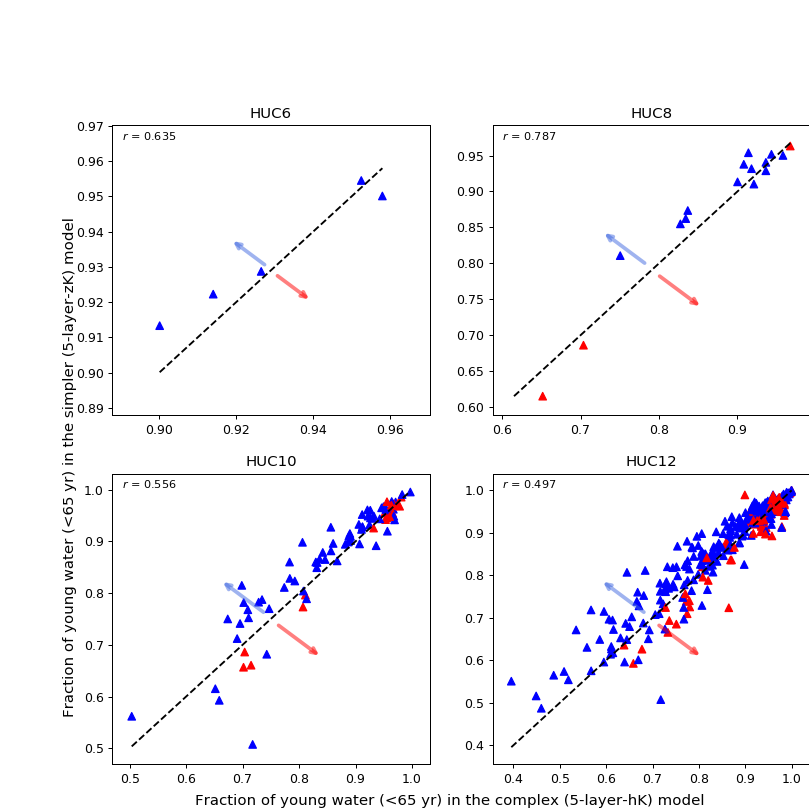

Processing HUCs for HUC6
Extracting zonal summary values from ../TIFFs/FWP5L_hK_SFRSWleak.tif for HUC6


C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in greater
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in greater
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in less
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRSWleak.tif for HUC6
Preparing plots for HUC6
Processing HUCs for HUC8
Extracting zonal summary values from ../TIFFs/FWP5L_hK_SFRSWleak.tif for HUC8


C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\numpy\lib\function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: All-NaN slice encountered
C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRSWleak.tif for HUC8
Preparing plots for HUC8
Processing HUCs for HUC10
Extracting zonal summary values from ../TIFFs/FWP5L_hK_SFRSWleak.tif for HUC10
Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRSWleak.tif for HUC10
Preparing plots for HUC10
Processing HUCs for HUC12
Extracting zonal summary values from ../TIFFs/FWP5L_hK_SFRSWleak.tif for HUC12
Extracting zonal summary values from ../TIFFs/FWP5L_zK_SFRSWleak.tif for HUC12
Preparing plots for HUC12


"\n# Add an attribute to the HUC shapefile\nshapefile = HUCshpdict[each]\npath = os.path.dirname(HUCshpdict[each])\nshp = gpd.read_file(shapefile)  \nshp[each] = shp[each].astype('int64')  # convert so can merge\n\nddd2.index = ddd2.index.astype('int64')  # convert so can merge\ndf = pd.merge(shp, ddd2, how='outer', left_on=each, right_index=True)\ndst = os.path.join(path, '{}_YF_{}_{}.shp'.format(each, fluxtype, metric))\ndf.to_file(dst)\n"

In [24]:
#### Process Flux result rasters differently -- Binary colors
# 1:1 plot of YoungFraction btwn 5LhK and 5LzK models for all HUC scales; color coded by differences in model output
# among the 5LhK and 5LzK models.  What's causing the YF differences?

topic = 'discharge'  # Chose between 'discharge' or 'seepage'.  Refers to dicts of tiffs for discharge to SFR cells or SFR cells seeping into aquifers
metric = 'mean'  # valid:  'mean', 'median', sum', min', 'max', 'range', 'std', 'count'

hucs = ['HUC6', 'HUC8', 'HUC10', 'HUC12']
nhucs = len(hucs)

# loop this thing
#for prop in HUCfluxrastlist:

#for Qkey, prop in dischargerastdict.items():
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axisdict = {0:ax1, 1:ax2, 2:ax3, 3:ax4}

for k, each in enumerate(hucs):
    # make sure we get ALL unique HUC IDs
    u1 = dfdict[eptlist[0]][each].unique()
    u2 = dfdict[eptlist[1]][each].unique()
    u3 = dfdict[eptlist[2]][each].unique()
    u = np.append(u1, u2)
    u = np.append(u, u3)
    uniques = np.unique(u)
    # remove any HUCs listed in purge_hucs
    for h in purge_hucs:
        ind = np.where(uniques==h)
        uniques = np.delete(uniques, ind)
    axis = axisdict[k]

    yfhucdict = {}
    yfvalues = []
    skiphuc = []
    for j, cat_val in enumerate(uniques.astype('int64')):  # each HUC ID
        yfmoddict = {}            
        for i, md in enumerate(eptlist):  # each of the 3 FWP models
            mn = modlist[i]
            df = dfdict[md].loc[dfdict[md][each]==cat_val]
            if df.rt.count() >= minptl:
                youngdf = df.loc[df.rt < age_cutoff]
                yf = youngdf.rt.count() / df.rt.count()
                yfmoddict[mn] = yf
                yfvalues.append(yf)
            else:
                skiphuc.append(cat_val)
                break
        if cat_val not in skiphuc:
            yfhucdict[cat_val] = yfmoddict    
    ddd = pd.DataFrame(yfhucdict).T
    for n in modlist:
        ddd = ddd.loc[~ddd[n].isnull()]  # need to remove any NANs
        
    # run zonal_stats on the merged df. Use the 'HUC' Tiffs to match up with model properties
    print('Processing HUCs for {}'.format(each))
    raster_file = HUCtiffdict[each]
    with rasterio.open(raster_file) as raster:
        hucrast = raster.read()[0]
        
    #Process the "evaluate rasters"
    for i in range(len(evaluate)):
        modnm = evaluate[i]
        if topic == 'discharge':
            prop = dischargerastdict[modnm]
        elif topic == 'seepage':
            prop = lossrastdict[modnm]
        else:
            print('only "discharge" or "seepage" are valid entries for the "topic" variable.  Stopping.')
            sys.exit()
        fluxtype = os.path.basename(prop).split('.')[0].split('_')[-1]  # type of info in the rasters
        print('Extracting zonal summary values from {} for {}'.format(prop, each))
        with rasterio.open(prop) as raster:
            fluxrast = raster.read()[0]
            if np.nanmax(fluxrast) <= 0.0:  # convert all negative arrays to positive
                fluxrast = fluxrast * -1
        if i == 0:
            mod_factor1 = abrevdict[modnm]
            descript1 = '{}_{}_{}'.format(metric, fluxtype, mod_factor1)
            firstflux = fluxrast.copy() 
            ddd1 = hucpropstats2(hucrast, firstflux, ddd, raster_file, metric, descript1) 
        elif i==1:
            mod_factor2 = abrevdict[modnm]
            descript2 = '{}_{}_{}'.format(metric, fluxtype, mod_factor2)
            # process second raster.
            ddd2 = hucpropstats2(hucrast, fluxrast, ddd1, raster_file, metric, descript2)
            fluxdiff = firstflux - fluxrast
            mod_factor3 = mod_factor1 + '-' + mod_factor2
            descript3 = '{}_{}_{}'.format(metric, fluxtype, mod_factor3)
            ddd2[descript3] = ddd2[descript1] - ddd2[descript2]
            descript4 = '%change_{}'.format(descript3)
            ddd2[descript4] = (ddd2[descript3] / ddd2[descript1]) * 100.0
            ddd2.replace([np.inf, -np.inf], np.nan)  # just in case infinity is calculated. Convert to nan before purge nan.
            ddd2 = ddd2.loc[ddd2[descript4].notnull()]  # remove any NANs
        else:
            print('Only 2 models were supposed to be listed in the EVALUATE variable.  Please fix that and re-run. Stopping.')
            sys.exit()
    
    print('Preparing plots for {}'.format(each))
    ddd2[mod_factor3] = ddd2[evaluate[0]] - ddd2[evaluate[1]]  # flux difference
    Srho_color, Sp_color = stats.spearmanr(np.array(ddd2[descript4]), np.array(ddd2[mod_factor3]))
    Prho_color, Pp_color = stats.pearsonr(np.array(ddd2[descript4]), np.array(ddd2[mod_factor3]))
    std_color = stats.tstd(np.array(ddd2[descript4]) - np.array(ddd2[mod_factor3]))
    ME_color = np.mean(np.array(ddd2[descript4]) - np.array(ddd2[mod_factor3]))
         
    #plotting
    mini = min(min(ddd2[evaluate[0]]), min(ddd2[evaluate[1]]))
    maxi = max(max(ddd2[evaluate[0]]), max(ddd2[evaluate[1]]))
    yrange = maxi-mini
    norm = MidpointNormalize(midpoint=0)
    ddd2['posneg'] = np.where(ddd2[descript4]>=0, 1, -1)  # make binary colors
    #ddd2.plot(kind='scatter', x=x1, y=y2, marker='^', c=ddd2[descript4], cmap='RdYlBu', norm=norm, ax=axis, vmax=ddd2[descript4].quantile(.99), vmin=ddd2[descript4].quantile(.01))
    #ddd2.plot(kind='scatter', x=x1, y=y2, marker='^', c=ddd2['posneg'], cmap='bwr', norm=norm, ax=axis, vmax=1, vmin=-1)
    s = axis.scatter(ddd2[x1], ddd2[y2], marker='^', c=ddd2['posneg'], cmap='bwr')
    lowlim = min(axis.get_xlim()[0], axis.get_ylim()[0])
    uplim = max(axis.get_xlim()[1], axis.get_ylim()[1])
    lims = (lowlim, uplim)
    lrange = uplim - lowlim
    axis.set_xlim(lims)  # force the plots to be square
    axis.set_ylim(lims)
    #axis.text(lowlim+0.03*lrange, uplim-0.11*lrange, 'Fit metrics between model \nproperty and YF differences:', fontsize=9)
    #axis.text(lowlim+0.03*lrange, uplim-0.16*lrange, r'$r$ = {:3.3f}  $p$={:1.1e}'.format(Prho_color, Pp_color), fontsize=9)
    axis.text(lowlim+0.03*lrange, uplim-0.05*lrange, r'$r$ = {:3.3f}'.format(Prho_color), fontsize=9)
    #axis.text(lowlim+0.03*lrange, uplim-0.21*lrange, r'$r_s$ = {:3.3f}  $p$={:1.1e}'.format(Srho_color, Sp_color), fontsize=9)
    #axis.text(lowlim+0.03*lrange, uplim-0.26*lrange, r'$std$ = {:3.3f}'.format(std_color), fontsize=9)
    #axis.text(lowlim+0.03*lrange, uplim-0.26*lrange, r'$ME$ = {:3.3f}'.format(ME_color), fontsize=9)
    pos1 = axis.get_position()
    axis.plot((mini, maxi), (mini, maxi), 'k--')
    axis.annotate("", xy=(mini+0.32*yrange, maxi-0.35*yrange), xytext=(mini+0.48*yrange, mini+0.52*yrange), arrowprops=dict(arrowstyle="->", lw=3, color='royalblue', alpha=0.5))  # orange or gray
    axis.annotate("", xy=(maxi-0.32*yrange, mini+0.35*yrange), xytext=(mini+0.52*yrange, mini+0.48*yrange), arrowprops=dict(arrowstyle="->", lw=3, color='red', alpha=0.5))  # royalblue
    axis.set_xlabel(''), axis.set_ylabel('')
    #axis.set_title(descript3)
    axis.set_title(each)  # HUC

fig.text(0.5, 0.105, 'Fraction of young water (<65 yr) in the complex (5-layer-hK) model', ha='center', fontsize=12)
fig.text(0.07, 0.48, 'Fraction of young water (<65 yr) in the simpler (5-layer-zK) model', va='center', fontsize=12, rotation='vertical')
plt.subplots_adjust(top = .86, bottom = 0.15)
#fig.suptitle('Comparison of Young Fraction by HUC scale, as informed by model \n'
#         'property:  %change in {} of {}'.format(metric, fluxtype), fontsize=16)

dst = '5L_YFCompare_by_%del_{}_of_{}_of_{}.png'.format(metric, fluxtype, mod_factor3)
dst_pth = os.path.join(fig_dir, dst)
f = plt.gcf()
f.savefig(dst_pth)
'''
# Add an attribute to the HUC shapefile
shapefile = HUCshpdict[each]
path = os.path.dirname(HUCshpdict[each])
shp = gpd.read_file(shapefile)  
shp[each] = shp[each].astype('int64')  # convert so can merge

ddd2.index = ddd2.index.astype('int64')  # convert so can merge
df = pd.merge(shp, ddd2, how='outer', left_on=each, right_index=True)
dst = os.path.join(path, '{}_YF_{}_{}.shp'.format(each, fluxtype, metric))
df.to_file(dst)
'''

In [ ]:
#### Process Flux result rasters differently
# 1:1 plot of meanYoungAge btwn 5LhK and 5LzK models for all HUC scales; color coded by differences in model output
# among the 5LhK and 5LzK models.  What's causing the age differences?

topic = 'discharge'  # Chose between 'discharge' or 'seepage'.  Refers to dicts of tiffs for discharge to SFR cells or SFR cells seeping into aquifers
metric = 'count'  # valid:  'mean', 'median', sum', min', 'max', 'range', 'std', 'count'

hucs = ['HUC6', 'HUC8', 'HUC10', 'HUC12']
nhucs = len(hucs)

# loop this thing
#for prop in HUCfluxrastlist:

#for Qkey, prop in dischargerastdict.items():
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axisdict = {0:ax1, 1:ax2, 2:ax3, 3:ax4}

for k, each in enumerate(hucs):
    # make sure we get ALL unique HUC IDs
    u1 = dfdict[eptlist[0]][each].unique()
    u2 = dfdict[eptlist[1]][each].unique()
    u3 = dfdict[eptlist[2]][each].unique()
    u = np.append(u1, u2)
    u = np.append(u, u3)
    uniques = np.unique(u)
    # remove any HUCs listed in purge_hucs
    for h in purge_hucs:
        ind = np.where(uniques==h)
        uniques = np.delete(uniques, ind)
    axis = axisdict[k]

    yfhucdict = {}
    yfvalues = []
    skiphuc = []
    for j, cat_val in enumerate(uniques.astype('int64')):  # each HUC ID
        yfmoddict = {}            
        for i, md in enumerate(eptlist):  # each of the 3 FWP models
            mn = modlist[i]
            df = dfdict[md].loc[dfdict[md][each]==cat_val]
            if df.rt.count() >= minptl:
                youngdf = df.loc[df.rt < 65]
                yfage = youngdf.rt.median()
                yfmoddict[mn] = yfage
                yfvalues.append(yfage)
            else:
                skiphuc.append(cat_val)
                break
        if cat_val not in skiphuc:
            yfhucdict[cat_val] = yfmoddict    
    ddd = pd.DataFrame(yfhucdict).T
    for n in modlist:
        ddd = ddd.loc[~ddd[n].isnull()]  # need to remove any NANs
        
    # run zonal_stats on the merged df. Use the 'HUC' Tiffs to match up with model properties
    print('Processing HUCs for {}'.format(each))
    raster_file = HUCtiffdict[each]
    with rasterio.open(raster_file) as raster:
        hucrast = raster.read()[0]
        
    #Process the "evaluate rasters"
    for i in range(len(evaluate)):
        modnm = evaluate[i]
        if topic == 'discharge':
            prop = dischargerastdict[modnm]
        elif topic == 'seepage':
            prop = lossrastdict[modnm]
        else:
            print('only "discharge" or "seepage" are valid entries for the "topic" variable.  Stopping.')
            sys.exit()
        fluxtype = os.path.basename(prop).split('.')[0].split('_')[-1]  # type of info in the rasters
        print('Extracting zonal summary values from {} for {}'.format(prop, each))
        with rasterio.open(prop) as raster:
            fluxrast = raster.read()[0]
            if np.nanmax(fluxrast) <= 0.0:  # convert all negative arrays to positive
                fluxrast = fluxrast * -1
        if i == 0:
            mod_factor1 = abrevdict[modnm]
            descript1 = '{}_{}_{}'.format(metric, fluxtype, mod_factor1)
            firstflux = fluxrast.copy()
            # process first raster and store to DF so can be manually evaluated or saved to disk.
            ddd1 = hucpropstats2(hucrast, firstflux, ddd, raster_file, metric, descript1) 
        elif i==1:
            mod_factor2 = abrevdict[modnm]
            descript2 = '{}_{}_{}'.format(metric, fluxtype, mod_factor2)
            # process second raster.
            ddd2 = hucpropstats2(hucrast, fluxrast, ddd1, raster_file, metric, descript2)
            fluxdiff = firstflux - fluxrast
            mod_factor3 = mod_factor1 + '-' + mod_factor2
            descript3 = '{}_{}_{}'.format(metric, fluxtype, mod_factor3)
            ddd2[descript3] = ddd2[descript1] - ddd2[descript2]
            descript4 = '%change_{}'.format(descript3)
            ddd2[descript4] = (ddd2[descript3] / ddd2[descript1]) * 100.0
            ddd2.replace([np.inf, -np.inf], np.nan)  # just in case infinity is calculated. Convert to nan before purge nan.
            ddd2 = ddd2.loc[ddd2[descript4].notnull()]  # remove any NANs
        else:
            print('Only 2 models were supposed to be listed in the EVALUATE variable.  Please fix that and re-run. Stopping.')
            sys.exit()
    
    print('Preparing plots for {}'.format(each))
    ddd2[mod_factor3] = ddd2[evaluate[0]] - ddd2[evaluate[1]]  # flux difference
    Srho_color, Sp_color = stats.spearmanr(np.array(ddd2[descript4]), np.array(ddd2[mod_factor3]))
    Prho_color, Pp_color = stats.pearsonr(np.array(ddd2[descript4]), np.array(ddd2[mod_factor3]))
    std_color = stats.tstd(np.array(ddd2[descript4]) - np.array(ddd2[mod_factor3]))
    ME_color = np.mean(np.array(ddd2[descript4]) - np.array(ddd2[mod_factor3]))

    #plotting
    mini = min(min(ddd[evaluate[0]]), min(ddd[evaluate[1]]))
    maxi = max(max(ddd[evaluate[0]]), max(ddd[evaluate[1]]))
    yrange = maxi-mini
    norm = MidpointNormalize(midpoint=0)
    ddd2.plot(kind='scatter', x=x1, y=y2, marker='^', c=ddd2[descript4], cmap='RdYlBu', norm=norm, ax=axis, vmax=ddd2[descript4].quantile(.99), vmin=ddd2[descript4].quantile(.01))
    lowlim = min(axis.get_xlim()[0], axis.get_ylim()[0])
    uplim = max(axis.get_xlim()[1], axis.get_ylim()[1])
    lims = (lowlim, uplim)
    lrange = uplim - lowlim
    axis.set_xlim(lims)  # force the plots to be square
    axis.set_ylim(lims)
    axis.text(lowlim+0.03*lrange, uplim-0.11*lrange, 'Fit metrics between model property \nand median YFage differences:', fontsize=9)
    axis.text(lowlim+0.03*lrange, uplim-0.16*lrange, r'$r_p$ = {:3.3f}  $p$={:1.1e}'.format(Prho_color, Pp_color), fontsize=9)
    axis.text(lowlim+0.03*lrange, uplim-0.21*lrange, r'$r_s$ = {:3.3f}  $p$={:1.1e}'.format(Srho_color, Sp_color), fontsize=9)
    axis.text(lowlim+0.03*lrange, uplim-0.26*lrange, r'$std$ = {:3.3f}'.format(std_color), fontsize=9)
    axis.text(lowlim+0.03*lrange, uplim-0.31*lrange, r'$ME$ = {:3.3f}'.format(ME_color), fontsize=9)
    pos1 = axis.get_position()
    axis.plot((mini, maxi), (mini, maxi), 'k--')
    axis.annotate("", xy=(mini+0.32*yrange, maxi-0.35*yrange), xytext=(mini+0.48*yrange, mini+0.52*yrange), arrowprops=dict(arrowstyle="->", lw=3, color='gray', alpha=0.3))  # orange
    axis.annotate("", xy=(maxi-0.32*yrange, mini+0.35*yrange), xytext=(mini+0.52*yrange, mini+0.48*yrange), arrowprops=dict(arrowstyle="->", lw=3, color='gray', alpha=0.3))  # royalblue
    axis.set_xlabel(''), axis.set_ylabel('')
    axis.set_title(descript3)
    axis.set_yticklabels(['{0:d}'.format(int(x)) for x in axis.get_yticks().tolist()])

fig.text(0.5, 0.105, 'Median YF age (yrs) for the 5-layer variable K model', ha='center', fontsize=12)
fig.text(0.07, 0.48, 'Median YF age (yrs) for the 5-layer zoned K model', va='center', fontsize=12, rotation='vertical')
plt.subplots_adjust(top = .86, bottom = 0.15)
fig.suptitle('Comparison of median Young Fraction ages by HUC scale,\n as informed by model '
         'property:  %change in {} of {}'.format(metric, fluxtype), fontsize=16)
dst = '5L_mYageCompare_by_%del_{}_of_{}_of_{}.png'.format(metric, fluxtype, mod_factor3)
dst_pth = os.path.join(fig_dir, dst)
f = plt.gcf()
f.savefig(dst_pth)

# Add an attribute to the HUC shapefile
shapefile = HUCshpdict[each]
path = os.path.dirname(HUCshpdict[each])
shp = gpd.read_file(shapefile)  
shp[each] = shp[each].astype('int64')  # convert so can merge

ddd2.index = ddd2.index.astype('int64')  # convert so can merge
df = pd.merge(shp, ddd2, how='outer', left_on=each, right_index=True)
dst = os.path.join(path, '{}_mYage_{}_{}.shp'.format(each, fluxtype, metric))
df.to_file(dst)

In [ ]:
'''
#Not really worth running this one comparing 5hK to the 1-layer model, cuz even more confounding differences.

# 1:1 plot of YF btwn 5LhK and 1LzK models for all HUC scales; color coded by differences in parameter
# values among the 5LhK and 1LzK models.  What's causing the "young-bias" in the 1-layer model? (where's it occuring).

# Use a special list of rasters for just this analysis
#L1_HUCproprastlist = ['../TIFFs/vK_lay1_5h-1z.tif', '../TIFFs/GlacT_5h-1z.tif',
#                 '../TIFFs/glac_satthick_5h-1z.tif', '../TIFFs/RCH_5h-1z.tif', 
#                 '../TIFFs/hK_lay1_5h-1z.tif']
L1_HUCproprastlist = ['../TIFFs/sat_thick_bedrock_4n5.tif']  # Would need to be trimmed to model domain for this one to work.

metric = 'mean'  # summary stat of the TIFF parameter.  valid entries:  'mean',  min', 'max', 'range', 'std'

hucs = ['HUC6', 'HUC8', 'HUC10', 'HUC12']
nhucs = len(hucs)
#fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
#axisdict = {0:ax1, 1:ax2, 2:ax3, 3:ax4}

# loop this thing
for prop in L1_HUCproprastlist:
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
    axisdict = {0:ax1, 1:ax2, 2:ax3, 3:ax4}
    
    for k, each in enumerate(hucs):
        # make sure we get ALL unique HUC IDs
        u1 = dfdict[eptlist[0]][each].unique()
        u2 = dfdict[eptlist[1]][each].unique()
        u3 = dfdict[eptlist[2]][each].unique()
        u = np.append(u1, u2)
        u = np.append(u, u3)
        uniques = np.unique(u)
        # remove any HUCs listed in purge_hucs
        for h in purge_hucs:
            ind = np.where(uniques==h)
            uniques = np.delete(uniques, ind)
        axis = axisdict[k]

        yfhucdict = {}
        yfvalues = []
        skiphuc = []
        for j, cat_val in enumerate(uniques.astype('int64')):  # each HUC ID
            yfmoddict = {}
            for i, md in enumerate(eptlist):  # each of the 3 FWP models
                mn = modlist[i]
                df = dfdict[md].loc[dfdict[md][each]==cat_val]
                if df.rt.count() >= minptl:
                    youngdf = df.loc[df.rt < age_cutoff]
                    yf = youngdf.rt.count() / df.rt.count()
                    yfmoddict[mn] = yf
                    yfvalues.append(yf)
                else:
                    skiphuc.append(cat_val)
                    break
            if cat_val not in skiphuc:
                yfhucdict[cat_val] = yfmoddict    

        ddd = pd.DataFrame(yfhucdict).T
        for n in modlist:
            ddd = ddd.loc[~ddd[n].isnull()]  # need to remove any NANs

        ddd[metric] = 0
        r2_y1 = r2_score(np.array(ddd[x1]), np.array(ddd[y1]))  #x1 = 5LheteroK; y1 = 1LzonedK

        print('Extracting zonal summary values from {} for {}'.format(prop, each))

        # run zonal_stats on the merged df. Use the 'HUC' Tiffs to match up with model properties
        raster_file = HUCtiffdict[each]
        with rasterio.open(raster_file) as raster:
            hucrast = raster.read()[0]
        #with rasterio.open(HUCproprast) as raster:
        with rasterio.open(prop) as raster:
            proprast = raster.read()[0]

        # Now pull out summary statistics for overlapping areas
        u = np.unique(hucrast)
        # Use a cross-reference approach for HUC10 and 12 cuz large INTs mess everything up!
        if max(u) < 10000:  # Less than any HUC6 ID number
            with open(raster_file.split('.')[0] + '_crossref.txt', mode='r') as infile:
                reader = csv.reader(infile)
                next(reader, None)  # skip the headers
                crossdict = {int(rows[0]):np.int64(rows[1]) for rows in reader}
        for ID in u[u>0]:  # HUC IDs in active part of model (not ID zero)
            idarr = np.zeros_like(hucrast)
            idarr[hucrast==ID] = 1
            # multiply by proprast, compute ave, min, max, range, std (median)
            hucprop = idarr * proprast
            hucprop[hucprop==0] = np.nan
            pmn, pmd, pmin, pmax, pstd = np.nanmean(hucprop), np.nanmedian(hucprop), np.nanmin(hucprop), np.nanmax(hucprop), np.nanstd(hucprop)
            prange = pmax - pmin
            metricdict = {'mean':pmn, 'median':pmd, 'min':pmin, 'max':pmax, 'range':prange, 'std':pstd}
            if max(u) < 10000:
                ddd[metric].loc[ddd.index==crossdict[ID]] = metricdict[metric].astype('float64')  # assigned the appropriate zonal data            
            else:
                ddd[metric].loc[ddd.index==ID] = metricdict[metric].astype('float64')  # assigned the appropriate zonal data

        #plotting
        mini, maxi = min(yfvalues), max(yfvalues)
        yrange = maxi-mini
        #if k == 0:
        #    ddd.plot(kind='scatter', x=x1, y=y2, marker='^', c=ddd[metric], cmap='viridis', label = '5-layer zoned K', ax=axis)
        #    axis.text(mini, mini+0.83*yrange, 'R2 = {:3.3f}'.format(r2_y2), fontsize=9)
        #else:

        ddd.plot(kind='scatter', x=x1, y=y1, marker='^', c=ddd[metric], cmap='viridis', ax=axis)  # How center on Zero?
        axis.text(mini, mini+0.95*yrange, 'R2 = {:3.3f}'.format(r2_y1), fontsize=9)
        pos1 = axis.get_position()
        axis.plot((mini, maxi), (mini, maxi), 'k--')
        axis.set_xlabel(''), axis.set_ylabel('')
        axis.set_title(each)

    fig.text(0.48, 0.89, 'Young fraction', fontsize=12)
    fig.text(0.5, 0.105, 'Young fraction for the 5-layer variable K model', ha='center', fontsize=12)
    fig.text(0.07, 0.48, 'Young fraction for the 1-layer zoned K model', va='center', fontsize=12, rotation='vertical')
    plt.subplots_adjust(top = .86, bottom = 0.15)
    #mod_factor = os.path.basename(HUCproprast).split('.')[0]
    mod_factor = os.path.basename(prop).split('.')[0]
    fig.suptitle('Comparison of Glacial water Young Fractions by HUC scale,\n as informed by model '
                 'property:  {} of {}'.format(metric, mod_factor), fontsize=16)

    dst = '5hK-1zK_YFcompare_by_{}_of_{}.png'.format(metric, mod_factor)
#    loc = os.path.dirname(path[modlist[0]])  # go up one directory to the dir that houses all of the models.
    dst_pth = os.path.join(fig_dir, dst)
    #plt.savefig(dst_pth)
    f = plt.gcf()
    f.savefig(dst_pth)
    #[f.get_axes()[4].remove() for x in range(4,8)] # remove the colorbars
#f.close()
#fig.close()
'''

In [ ]:
''' This is the wrong way of processing the flux rasters


#### Process Flux result rasters differently
# 1:1 plot of meanYoungAge btwn 5LhK and 5LzK models for all HUC scales; color coded by differences in model output
# among the 5LhK and 5LzK models.  What's causing the age differences?

evaluation = 'nneg'  # valid:  npos, nneg, posdif, negdif, flux.  
                        #These describe the difference in flux (5h-5z), with flux being negative to begin with, 
                        #so "neg" means that 5H had more discharge, "pos" means 5Z had more discharge.
metric = 'sum'  # valid:  'mean', 'median', sum', min', 'max', 'range', 'std'

hucs = ['HUC6', 'HUC8', 'HUC10', 'HUC12']
nhucs = len(hucs)

# loop this thing
for prop in HUCfluxrastlist:
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    axisdict = {0:ax1, 1:ax2, 2:ax3, 3:ax4}
    mod_factor = os.path.basename(prop).split('.')[0]
    
    for k, each in enumerate(hucs):
        # make sure we get ALL unique HUC IDs
        u1 = dfdict[eptlist[0]][each].unique()
        u2 = dfdict[eptlist[1]][each].unique()
        u3 = dfdict[eptlist[2]][each].unique()
        u = np.append(u1, u2)
        u = np.append(u, u3)
        uniques = np.unique(u)
        # remove any HUCs listed in purge_hucs
        for h in purge_hucs:
            ind = np.where(uniques==h)
            uniques = np.delete(uniques, ind)
        axis = axisdict[k]

        yfhucdict = {}
        yfvalues = []
        skiphuc = []
        for j, cat_val in enumerate(uniques.astype('int64')):  # each HUC ID
            yfmoddict = {}            
            for i, md in enumerate(eptlist):  # each of the 3 FWP models
                mn = modlist[i]
                df = dfdict[md].loc[dfdict[md][each]==cat_val]
                if df.rt.count() >= minptl:
                    youngdf = df.loc[df.rt < 65]
                    yfage = youngdf.rt.median()
                    yfmoddict[mn] = yfage
                    yfvalues.append(yfage)
                else:
                    skiphuc.append(cat_val)
                    break
            if cat_val not in skiphuc:
                yfhucdict[cat_val] = yfmoddict    
        ddd = pd.DataFrame(yfhucdict).T
        for n in modlist:
            ddd = ddd.loc[~ddd[n].isnull()]  # need to remove any NANs

        r2_y2 = r2_score(np.array(ddd[x1]), np.array(ddd[y2]))  #x1 = 5LheteroK; y2 = 5LzonedK
        #plotting
        mini, maxi = min(yfvalues), max(yfvalues)
        yrange = maxi-mini
        
        print('Extracting zonal summary values from {} for {}'.format(prop, each))
        # run zonal_stats on the merged df. Use the 'HUC' Tiffs to match up with model properties
        raster_file = HUCtiffdict[each]
        with rasterio.open(raster_file) as raster:
            hucrast = raster.read()[0]
        with rasterio.open(prop) as raster:
            fluxrast = raster.read()[0]
            posrast = np.where(fluxrast>0, fluxrast, 0)
            negrast = np.where(fluxrast<0, fluxrast, 0)
            nposrast = np.where(fluxrast>0, 1, 0)
            nnegrast = np.where(fluxrast<0, 1, 0)
        fluxdict = {'flux':fluxrast, 'posdif':posrast, 'negdif':negrast, 'npos':nposrast, 'nneg':nnegrast}
        for key, valrast in fluxdict.items():  # just plot one type at a time.
            if key == evaluation:  # valid:  num_pos, num_neg, possitive, negative, flux.
                #ddd2 = hucpropstats(hucrast, valrast, ddd, metric, raster_file)
                #ddd2.plot(kind='scatter', x=x1, y=y2, marker='^', c=ddd2[metric], cmap='viridis', ax=axis)  # How center on Zero?
                ddd2, descriptor = hucpropstats(hucrast, valrast, ddd, raster_file, metric, evaluation, mod_factor)
                ddd2.plot(kind='scatter', x=x1, y=y2, marker='^', c=ddd2[descriptor], cmap='viridis', ax=axis, vmax=ddd2[descriptor].quantile(.99))  # How center on Zero?
                axis.text(mini, mini+0.95*yrange, 'R2 = {:3.3f}'.format(r2_y2), fontsize=9)
                pos1 = axis.get_position()
                axis.plot((mini, maxi), (mini, maxi), 'k--')
                axis.set_xlabel(''), axis.set_ylabel('')
                axis.set_title(each + '_' + evaluation)

    fig.text(0.35, 0.89, 'Young Fraction Median age ', fontsize=12)
    fig.text(0.5, 0.105, 'Median age (yrs) for the 5-layer variable K model', ha='center', fontsize=12)
    fig.text(0.07, 0.48, 'Median age (yrs) for the 5-layer zoned K model', va='center', fontsize=12, rotation='vertical')
    plt.subplots_adjust(top = .86, bottom = 0.15)
    fig.suptitle('Comparison of median Glacial Young ages by HUC scale,\n as informed by model '
             'property:  {} of {} of {}'.format(metric, evaluation, mod_factor), fontsize=16)
    dst = '5L_mYageCompare_by_{}_of_{}_of_{}.png'.format(metric, evaluation, mod_factor)
    dst_pth = os.path.join(fig_dir, dst)
    f = plt.gcf()
    f.savefig(dst_pth)
    
    
    # Add an attribute to the HUC shapefile
    #shapefile = os.path.basename(HUCshpdict[each]) + '_mYage.shp'
    #shp = gpd.read_file(shapefile)  
    #shp[each] = shp[each].astype('int64')  # convert so can merge
    
    #young.index = young.index.astype('int64')  # convert so can merge
    #young['mYage_hK-1L'] = young[x1] - young[y1]
    #young['mYage_hK-zK'] = young[x1] - young[y2]
    #df = pd.merge(shp, young, how='outer', left_on=each, right_index=True)
    #dst = shapefile[:-4] + '_mYage.shp'
    #df.to_file(dst)
'''